In [1]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
import pprint
import h5py 
# import lsqfitics
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.fpi_fit as fpi_fit
import xpt.plots as plots
import xpt.fit_comparison as compare 

import tests.tests as tests
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')
data_dir = os.path.join(project_root, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
data_path_input = os.path.join(data_dir, "input_data.h5")


/Users/grantdb/lqcd/hyperon-xpt-master


In [2]:
from importlib import reload
reload(xfa)
reload(i_o)
reload(fit)
reload(priors)

<module 'xpt.priors' from '/Users/grantdb/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
# bootstrapped hyperon correlator data
with h5py.File(hyperon_data_file, 'r') as f:
    ens_hyp = sorted(list(f.keys()))
    ens_hyp = sorted([e.replace('_hp', '') for e in  ens_hyp])

# bootstrapped scale setting data 
with h5py.File(data_path_input, 'r') as f: 
    ens_in = sorted(list(f.keys()))

ensembles = sorted(list(set(ens_hyp) & set(ens_in)))
ensembles = sorted(list(set(ens_hyp) & set(ens_in)))
# hopefully with new data these can be safely re-added
ensembles.remove('a12m220')
ensembles.remove('a12m220ms')
ensembles.remove('a12m310XL')
ensembles.remove('a12m220S')
ensembles.remove('a12m180L')

# print(ensembles)
to_gvar = lambda arr : gv.gvar(arr[0], arr[1])

data = {}
with h5py.File(data_dir+'/input_data.h5','r') as f: 
    for ens in ensembles:
        data[ens] = {}
        # data[ens] = f[ens]['a_fm']['w0_imp'][:]
        data[ens]['a_fm'] = f[ens]['a_fm']['w0_org'][:] # make each ens fully decorrelated with one another 
print(data,'h5')

# print(gv.evalcorr([data['a09m220']['a_fm'],data['a09m400']['a_fm']]))
# print(gv.evalcorr([data['a12m220L']['a_fm'],data['a09m400']['a_fm']]))
a_fm =  gv.load(data_dir +'/a_fm_results.p')
hbarc =  gv.gvar(197.3269804, 0)

print(a_fm, 'a_fm')
data['a09m220']['units_MeV'] = hbarc /a_fm['a09'] 
data['a09m310']['units_MeV'] = hbarc /a_fm['a09'] 






{'a06m310L': {'a_fm': array([0.05717, 0.00051])}, 'a09m135': {'a_fm': array([0.08789, 0.00071])}, 'a09m220': {'a_fm': array([0.08789, 0.00071])}, 'a09m310': {'a_fm': array([0.08789, 0.00071])}, 'a09m350': {'a_fm': array([0.08789, 0.00071])}, 'a09m400': {'a_fm': array([0.08789, 0.00071])}, 'a12m130': {'a_fm': array([0.12126, 0.00087])}, 'a12m220L': {'a_fm': array([0.12126, 0.00087])}, 'a12m310': {'a_fm': array([0.12126, 0.00087])}, 'a12m350': {'a_fm': array([0.12126, 0.00087])}, 'a12m400': {'a_fm': array([0.12126, 0.00087])}, 'a15m135XL': {'a_fm': array([0.1492, 0.001 ])}, 'a15m220': {'a_fm': array([0.1492, 0.001 ])}, 'a15m310': {'a_fm': array([0.1492, 0.001 ])}, 'a15m310L': {'a_fm': array([0.1492, 0.001 ])}, 'a15m350': {'a_fm': array([0.1492, 0.001 ])}, 'a15m400': {'a_fm': array([0.1492, 0.001 ])}} h5
{'a15': 0.15036(98), 'a12': 0.12055(83), 'a09': 0.08722(67), 'a06': 0.05686(49)} a_fm


Testing discarding of off-diag. elements of covariance matrix. 
- In theory, this should only remove the correlations between the correlators of different strangeness 

In [14]:
reload(i_o)
xi_particles = ['xi','xi_st']
data_partial, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit='phys',system='all',scheme='w0_imp',convert_data=False,decorr_scale=None,decorr_scale_full=False,partial_decorr=True)
data_decorr, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit='phys',system='all',scheme='w0_imp',convert_data=False,decorr_scale=True,partial_decorr=False,decorr_scale_full=False)
data_decorr_full, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit='phys',system='all',scheme='w0_imp',convert_data=False,decorr_scale_full=True,partial_decorr = False,decorr_scale=False)

print(gv.evalcorr(data_partial['units_MeV']))
print(gv.evalcorr(data_decorr['units_MeV']))
print(gv.evalcorr(data_decorr_full['units_MeV']))

# print(data)
data_subset = {part:data['m_'+part] for part in xi_particles}
# print(gv.evalcov(data_subset))
# print(gv.rebuild(data_subset))
discard = { k : gv.gvar(gv.mean(data['m_'+k]), gv.sdev(data['m_'+k])) for k in data_subset}
# print(gv.evalcov(discard))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]
[[1.         0.92717811 0.92717811 0.92717811 0.92717811 0.92717811
  0.86653435 

KeyError: 'm_xi'

In [ ]:
a_fm = gv.load('../data/a_fm_results.p')
to_gvar = lambda arr : gv.gvar(arr[0], arr[1])
print(a_fm)
scale = gv.load('../scale_setting.p')
print(scale)
data  = {}
for ens in ['a06','a09','a12','a15']:
    data[ens] = a_fm[ens]
data

{'a15': 0.15036(98), 'a12': 0.12055(83), 'a09': 0.08722(67), 'a06': 0.05686(49)}
{'w0_org:a06': 2.986(12), 'w0_org:a09': 1.9443(55), 'w0_org:a12': 1.4107(29), 'w0_org:a15': 1.1451(12), 'w0_org:w0': 0.1713(12), 't0_org:a06': 6.587(25), 't0_org:a09': 3.0382(77), 't0_org:a12': 1.7570(33), 't0_org:a15': 1.2376(16), 't0_org:sqrt_t0': 0.1414(12), 'w0_imp:a06': 2.997(12), 'w0_imp:a09': 1.9556(54), 'w0_imp:a12': 1.4163(29), 'w0_imp:a15': 1.1341(15), 'w0_imp:w0': 0.1716(12), 't0_imp:a06': 6.234(26), 't0_imp:a09': 2.7139(80), 't0_imp:a12': 1.4693(32), 't0_imp:a15': 0.9920(13), 't0_imp:sqrt_t0': 0.1418(11), 'meta': {'original_scales': '2023_06_20-original_simultaneous', 'improved_scales': '2023_06_20-improved_simultaneous'}}


{'a06': 0.05686(49),
 'a09': 0.08722(67),
 'a12': 0.12055(83),
 'a15': 0.15036(98)}

In [ ]:
a_fm

BufferDict({'a15': 0.15036(98), 'a12': 0.12055(83), 'a09': 0.08722(67), 'a06': 0.05686(49)})

In [ ]:
# gv.load('../scale_setting.p')
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
lam_sigma_models = models['models']['lam_sigma_system']

## $ S=2: \Xi, \Xi^*$ system ##
1. Fit $M_H/ \Lambda_\Chi$ in $F_\pi$ units, then extrapolate to physical pt.

We can determine $M_H$ by fitting the dimensionless observable $\frac{M_H}{\Lambda_\Chi}$. In order to perform an extrapolation to the physical point, we subsequently multiply by $\Lambda_\Chi^*$, eg. the physical value. 
Differences between the following fit strategy and the fits obtained via directly fitting $M_H$ via scale setting, as previously performed:

    - Discertization and strange quark terms no longer need to be rescaled (eg. not multiplied through by $M_H^0$)
    - Need to take into account the $\Lambda_\Chi$ expansion, which depends on $F_\pi$ 
      - However, we can treat this llo term as a constant when performing a pure taylor fit (will differ by ensemble)
      - 
Let us first determine the highest weight model then study the effect of discarding the off-diagonal terms in the covariance matrix 

Top weighted model key: xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-False
Weight: 0.9332658752792581
Fit Result for xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-False:
Least Square Fit:
  chi2/dof [dof] = 0.69 [34]    Q = 0.91    logGBF = 95.983

Parameters:
       m_{xi,0}       1.128 (10)       [      1.0 (1.0) ]  
         s_{xi}        0.04 (29)       [      0.0 (2.0) ]  
         S_{xi}      -6e-16 +- 2       [      0.0 (2.0) ]  
       b_{xi,4}       -2.2 (1.1)       [      0.0 (2.0) ]  *
       B_{xi,4}      -2e-18 +- 2       [      0.0 (2.0) ]  
       d_{xi,a}       -0.34 (11)       [     -2.0 (2.0) ]  
      d_{xi,aa}       -0.11 (41)       [      2.0 (4.0) ]  
      d_{xi,al}        2.57 (56)       [      0.0 (5.0) ]  
       d_{xi,s}        0.90 (18)       [      0.0 (5.0) ]  
    m_{xi_st,0}       1.304 (12)       [      1.2 (1.0) ]  
     s_{xi,bar}      -2e-16 +- 2       [      0.0 (2.0) ]  
     S_{xi,bar}       1e-15 +- 2       [      0.0 (2.0) ]  
    b_{xi_st,4}       -4.0 

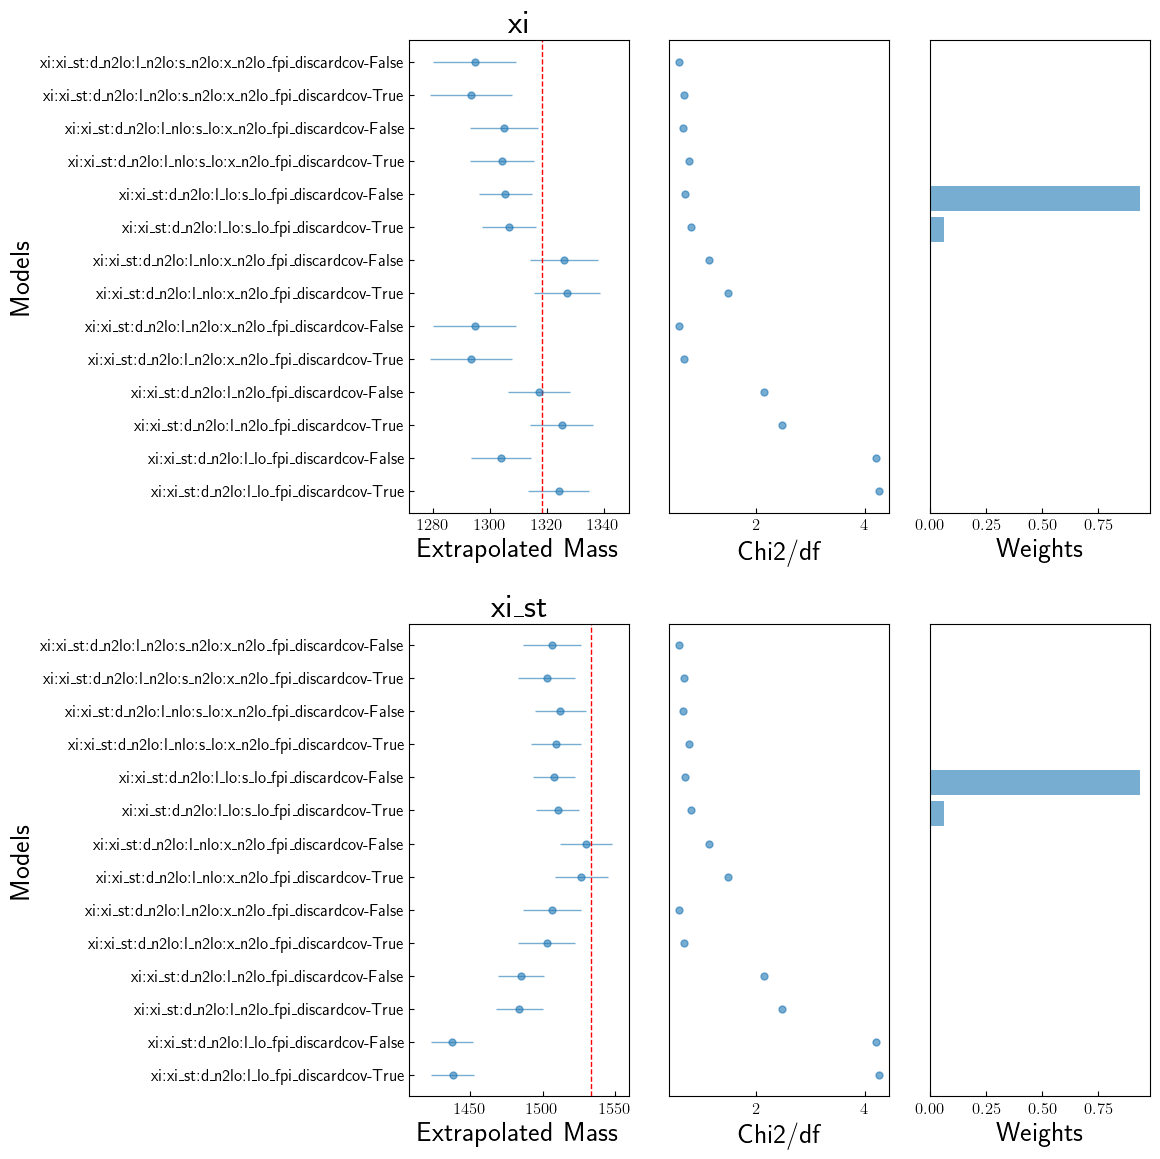

In [ ]:
reload(i_o)
reload(xfa)
reload(fit)
reload(compare)

fpi_all = compare.run_analysis(units='fpi',strange='2',compare_models=True,verbose=False)
print(fpi_all)

In [ ]:
reload(xfa)
fpi_top = compare.run_analysis(units='fpi',strange='2',compare_models=False,verbose=False,test_mdl_key='xi:xi_st:d_n2lo:l_lo:s_lo')
print(fpi_top)

{'name': 'xi:xi_st:d_n2lo:l_n2lo:s_lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chiral': None, 'order_disc': 'n2lo', 'order_strange': 'lo', 'order_light': 'n2lo', 'xpt': False, 'fv': True, 'units': 'phys', 'convert_data_before': False, 'emp_bayes': False, 'emp_bayes_grouping': None}
Results for fitting in fpi units:
xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-True

---
Extrapolation:
Particle: xi
mass: 1306.6(9.5) [PDG: 1315(20)]
---
Particle: xi_st
mass: 1510(15) [PDG: 1532(32)]
---

Error Budget:
xi
  stat    79.0%
  pp      20.9%
  chiral   6.1%
  disc     0.8%
xi_st
  stat    88.0%
  pp      11.9%
  disc     0.7%
  chiral   0.2%
Least Square Fit:
  chi2/dof [dof] = 0.79 [34]    Q = 0.81    logGBF = 93.271

Parameters:
       m_{xi,0}       1.12951 +- 0.0107413            [                   1 +- 1 ]  
         s_{xi}      0.0134881 +- 0.314565            [                   0 +- 2 ]  
         S_{xi}           2.97045e-16 +- 2            [                   0 +- 2

## $S=1$ system

Top weighted model key: lam:sigma:sigma_st:l_n2lo:d_n2lo:s_lo_fpi_discardcov-False
Weight: 0.32736819588036853
Fit Result for lam:sigma:sigma_st:l_n2lo:d_n2lo:s_lo_fpi_discardcov-False:
Least Square Fit:
  chi2/dof [dof] = 0.88 [51]    Q = 0.71    logGBF = 135.02

Parameters:
   m_{lambda,0}       0.947 (15)       [      1.3 (1.0) ]  
     s_{lambda}        3.0 (2.0)       [      3.0 (2.0) ]  
     S_{lambda}        0.75 (49)       [      3.0 (2.0) ]  *
   b_{lambda,4}       -3.6 (1.7)       [      0.0 (5.0) ]  
   B_{lambda,4}       8e-16 +- 5       [      0.0 (5.0) ]  
   d_{lambda,a}       -0.25 (15)       [      0.0 (2.0) ]  
  d_{lambda,aa}       -0.02 (54)       [      0.0 (4.0) ]  
  d_{lambda,al}        1.77 (82)       [      0.0 (4.0) ]  
   d_{lambda,s}        0.35 (31)       [      0.0 (2.0) ]  
    m_{sigma,0}       1.017 (14)       [      1.4 (1.0) ]  
      s_{sigma}      -2e-16 +- 2       [      0.0 (2.0) ]  
      S_{sigma}        0.88 (45)       [      0.0 (2.0) ]  
  

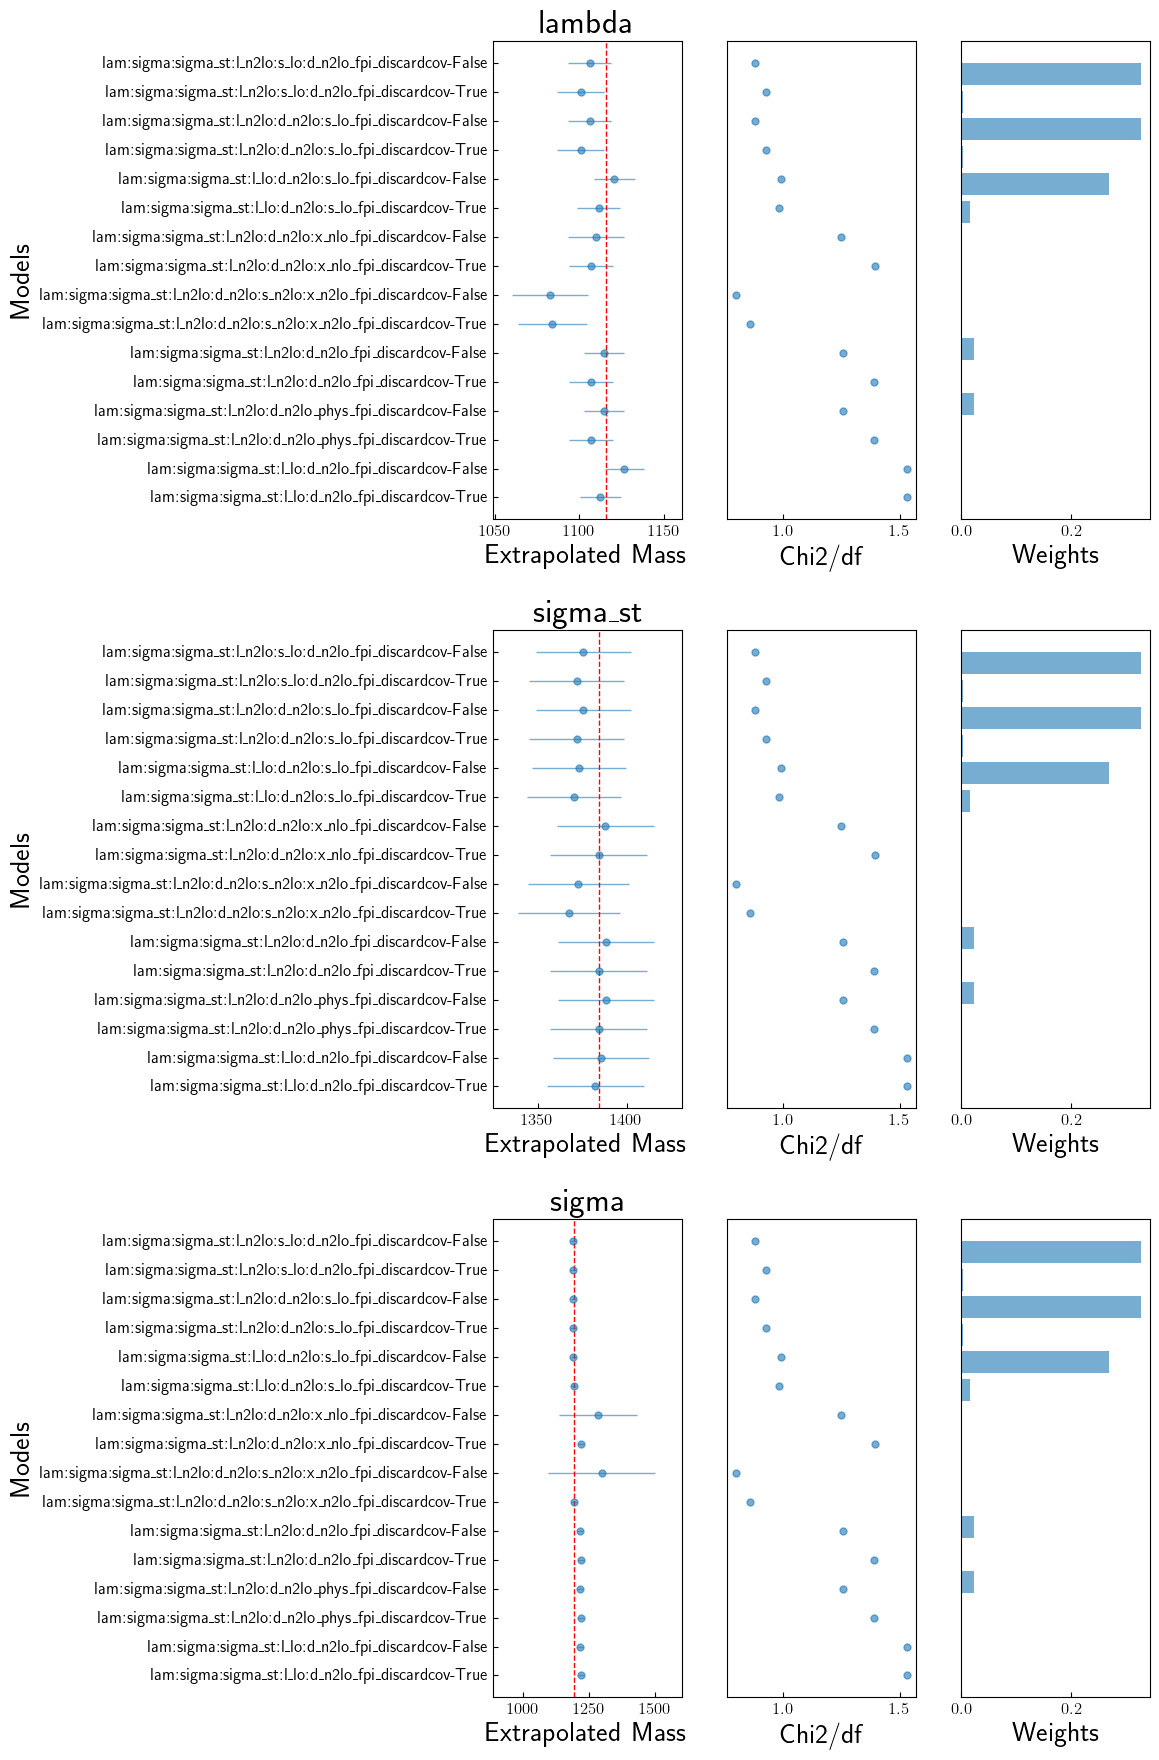

In [ ]:
reload(i_o)
reload(xfa)
reload(fit)
reload(compare)
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sigma_models = models['models']['lam_sigma_system']

fpi_all = compare.run_analysis(units='fpi',strange='1',compare_models=True,verbose=False)
print(fpi_all)

dict_keys(['xi:xi_st:d_n2lo:l_lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_n2lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_n2lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_n2lo:x_n2lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_n2lo:x_n2lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_nlo:x_n2lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_nlo:x_n2lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo_fpi_discardcov-False', 'xi:xi_st:d_n2lo:l_n2lo:s_n2lo:x_n2lo_fpi_discardcov-True', 'xi:xi_st:d_n2lo:l_n2lo:s_n2lo:x_n2lo_fpi_discardcov-False'])
({'xi': 1304(23), 'xi_st': 1513(26)}, {'xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-False': 0.9332658752792581, 'xi:xi_st:d_n2lo:l_lo:s_lo_fpi_discardcov-True': 0.06198744730366017, 'xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo_fpi_discardcov-False': 0.0016443971009772616,

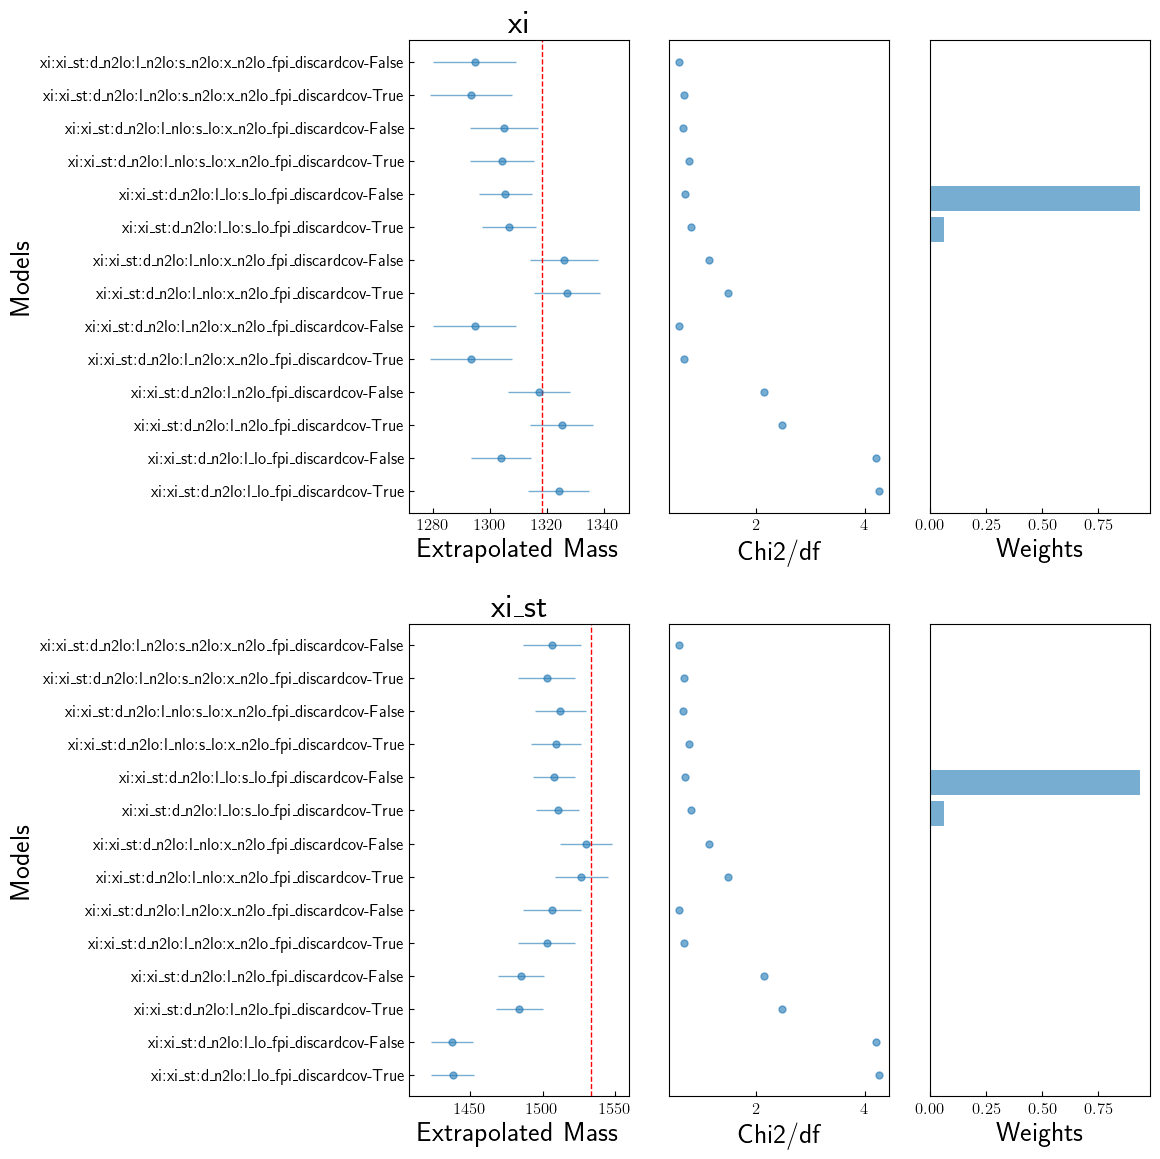

In [ ]:
reload(i_o)
reload(xfa)
reload(fit)

units_list = ['fpi']
discard_cov_opt = [True,False] # this option either retains the correlations between the pseudoscalars (scale setting params) or removes them # 
model_data = {}
test_mdl_key = 'xi:xi_st:d_n2lo:l_n2lo:s_n2lo:x_n2lo'

for unit in units_list:
    data, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=False,decorr_scale=None)
    
    for mdl_key in xi_models:
        _model_info = xi_models[mdl_key].copy()
        _model_info['units'] = unit
        updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
    # print(f"Processing: {updated_mdl_key}")  
        for dc in discard_cov_opt:
            xfa_instance = xfa.Xpt_Fit_Analysis(data=data,
                                            prior=new_prior,
                                            model_info=_model_info,
                                            phys_pt_data=phys_point_data,
                                            units=unit,
                                            extrapolate=True,
                                            discard_cov=dc,
                                            verbose=False,
                                            svd_test=False,
                                            svd_tol=None)
            config_key = f"{updated_mdl_key}_discardcov-{dc}"
        
            model_data[config_key] = xfa_instance  

    print(model_data.keys())

    # print(model_data['xi:xi_st:d_n2lo:l_lo_fpi'])

# Print the results
for key, value in model_data.items():
    # Extract the unit from the key assuming the unit was appended to the original key.
    unit_from_info = value.model_info['units']
    # print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
    # print(key)
    # print(value)
    # print("-" * 80)

reload(compare)
compare_ = compare.ModelComparsion(models=model_data,compare_type='fpi',units='fpi')
compare_.compare_models(particles=['xi','xi_st'])
mdl_avg = compare_.model_average(particles=['xi','xi_st'])
print(mdl_avg)
compare_.model_plots(system='xi')

{
    'xi':
    array([1.0682(41), 1.1064(50), 1.0865(42), 1.0587(23), 1.0491(26),
           1.0273(24), 1.0871(31), 1.0600(38), 1.0432(26), 1.0320(33),
           1.0184(25), 1.0705(24), 1.0483(18), 1.0406(16), 1.0291(30),
           1.0284(36), 1.0165(35)], dtype=object),
    'xi_st':
    array([1.2446(89), 1.3176(90), 1.289(13), 1.251(13), 1.232(17),
           1.2164(50), 1.3127(61), 1.2854(34), 1.2506(57), 1.2351(70),
           1.2166(48), 1.2998(43), 1.2656(65), 1.2519(18), 1.2419(32),
           1.2282(68), 1.2127(61)], dtype=object),
}
{'a06m310L': 0.806(60), 'a09m135': 0.816(72), 'a09m220': 0.811(67), 'a09m310': 0.810(61), 'a09m350': 0.808(58), 'a09m400': 0.801(55), 'a12m130': 0.820(72), 'a12m220L': 0.811(67), 'a12m310': 0.810(61), 'a12m350': 0.804(58), 'a12m400': 0.800(55), 'a15m135XL': 0.814(72), 'a15m220': 0.814(67), 'a15m310': 0.812(60), 'a15m310L': 0.807(61), 'a15m350': 0.803(58), 'a15m400': 0.797(54)}


extrapolation as fcn of pion mass
extrapolation as fcn of lattice 

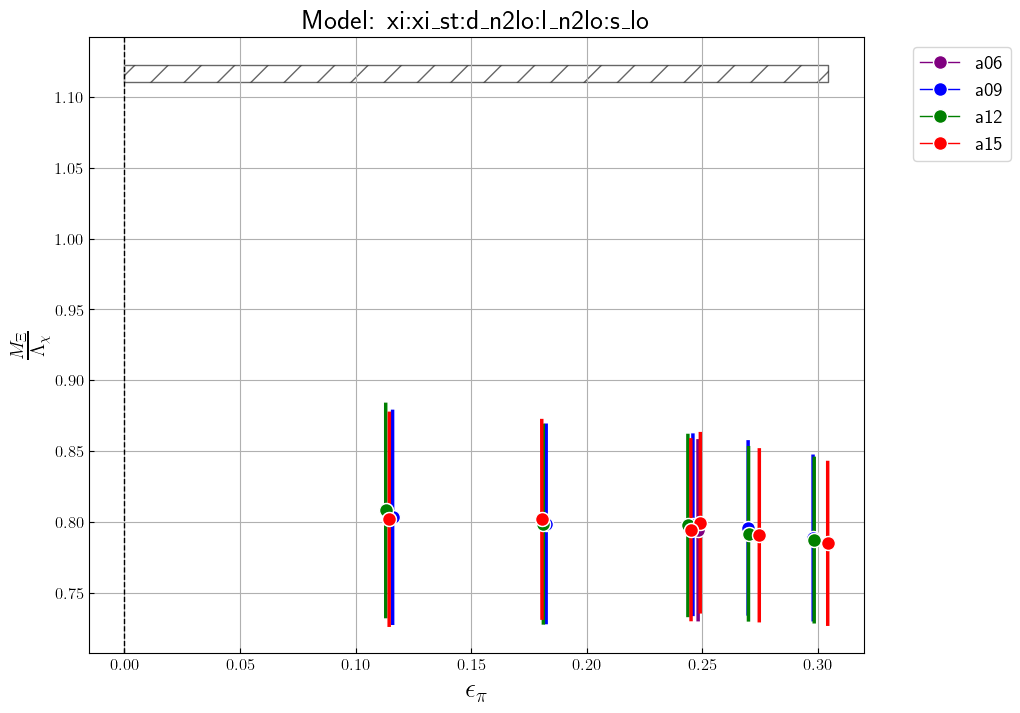

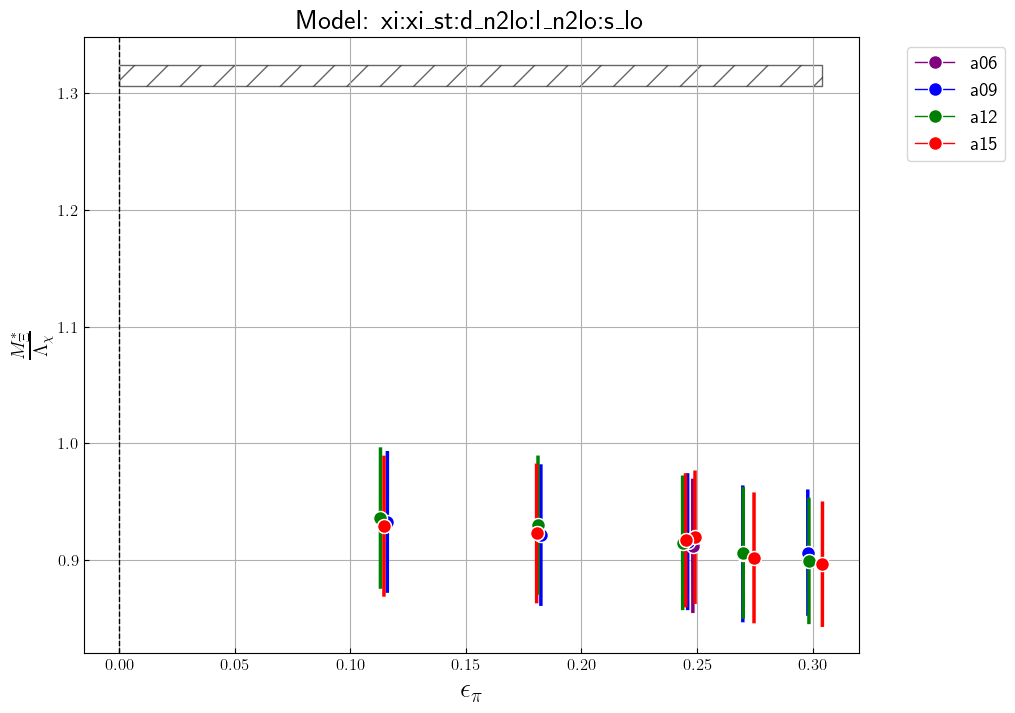

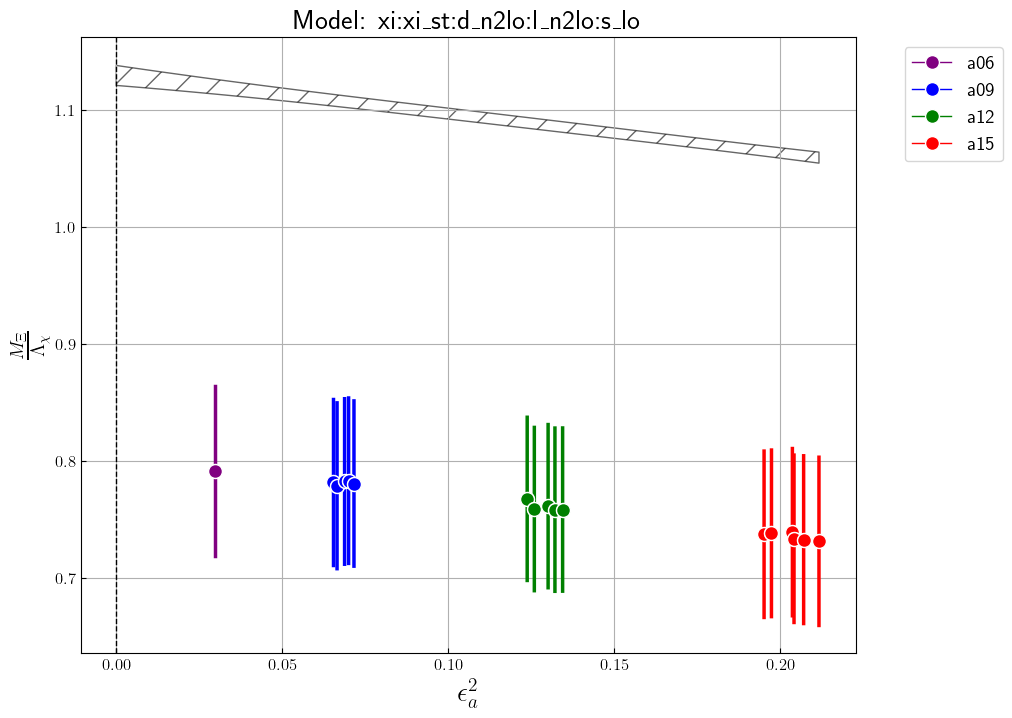

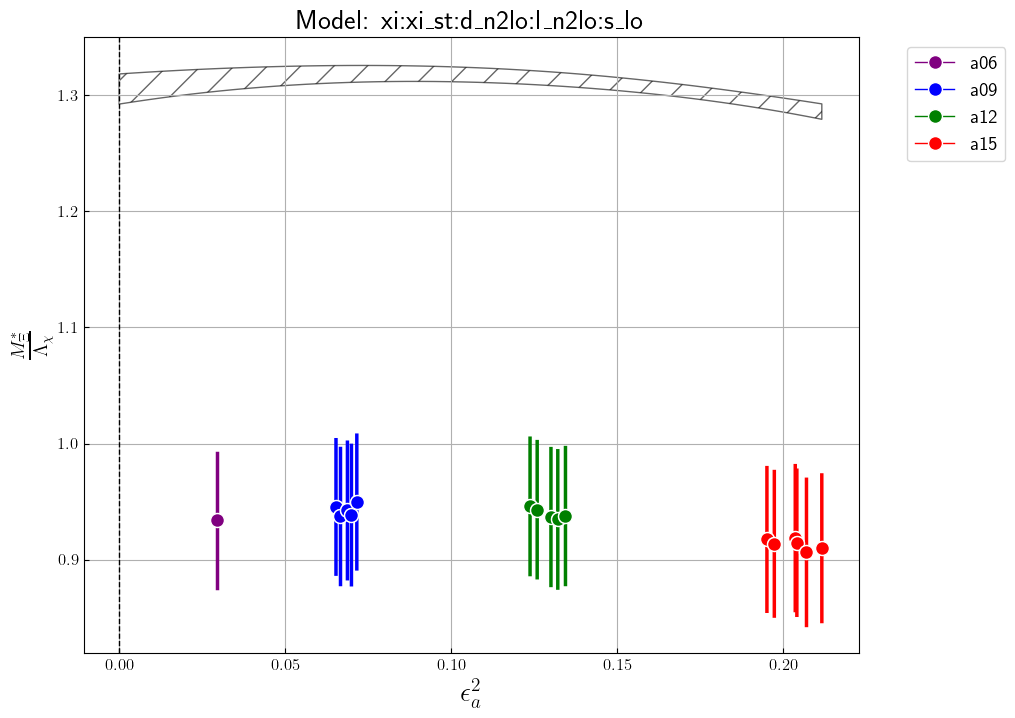

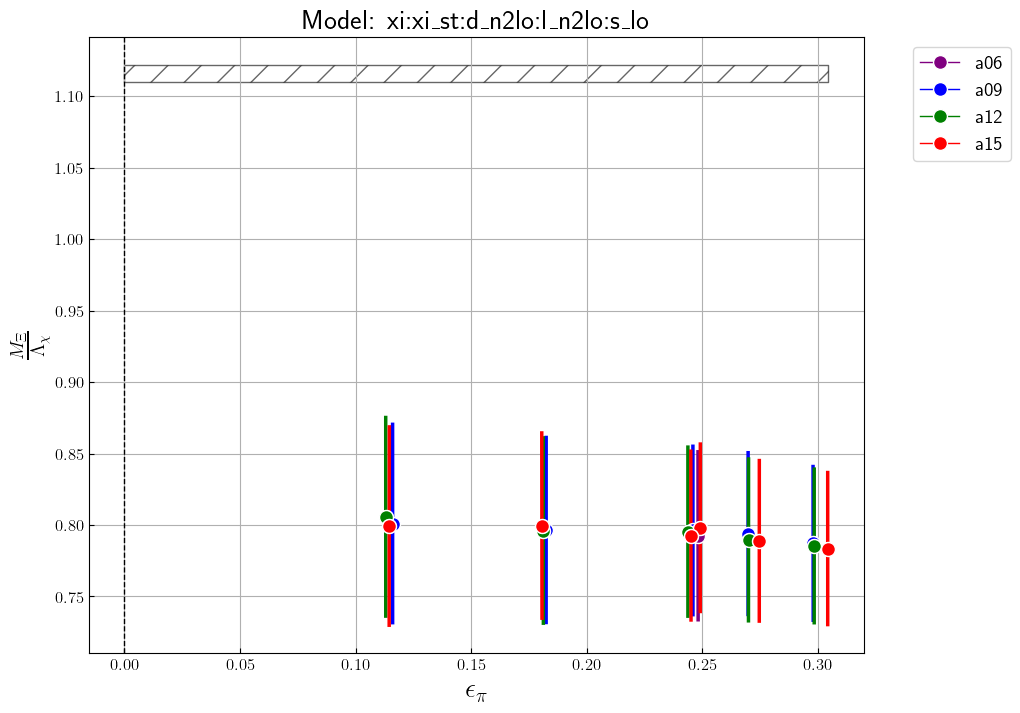

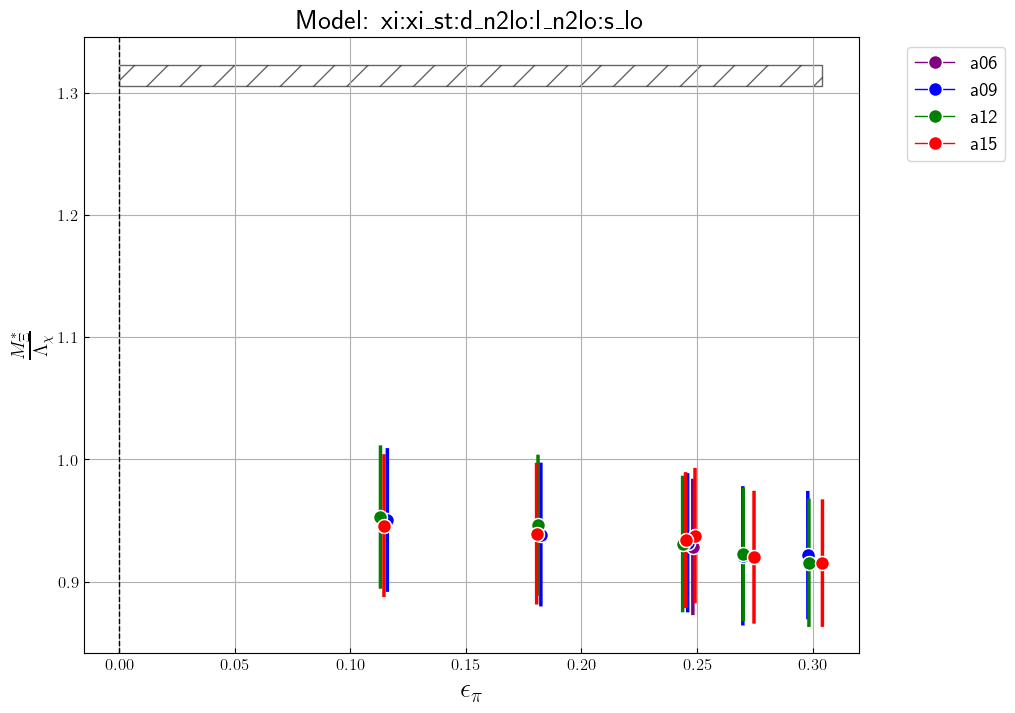

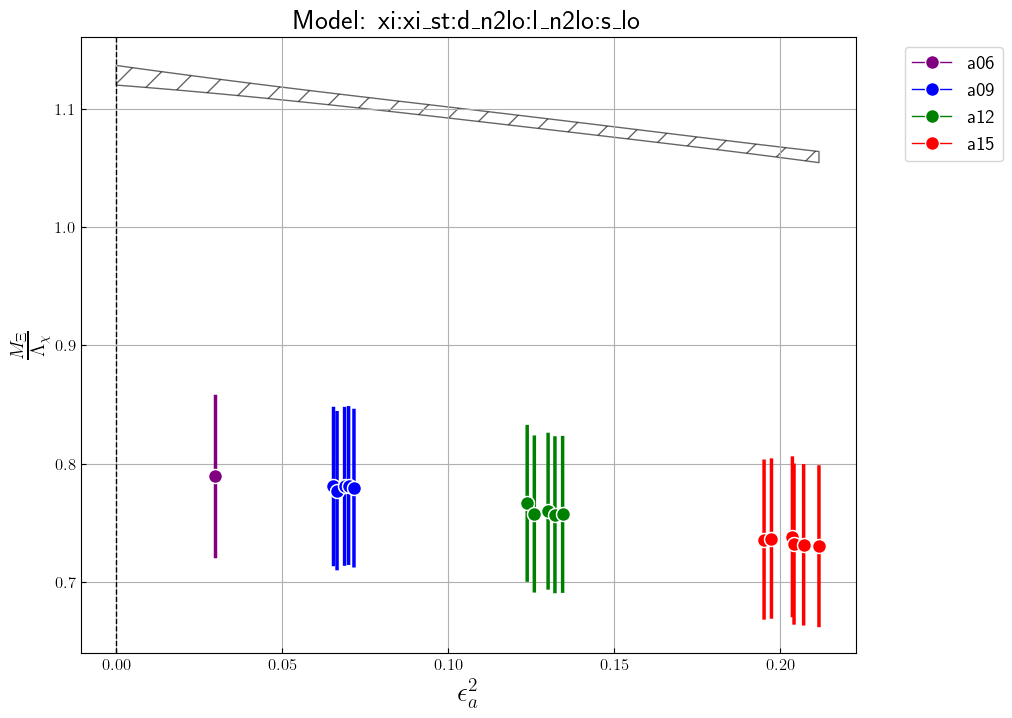

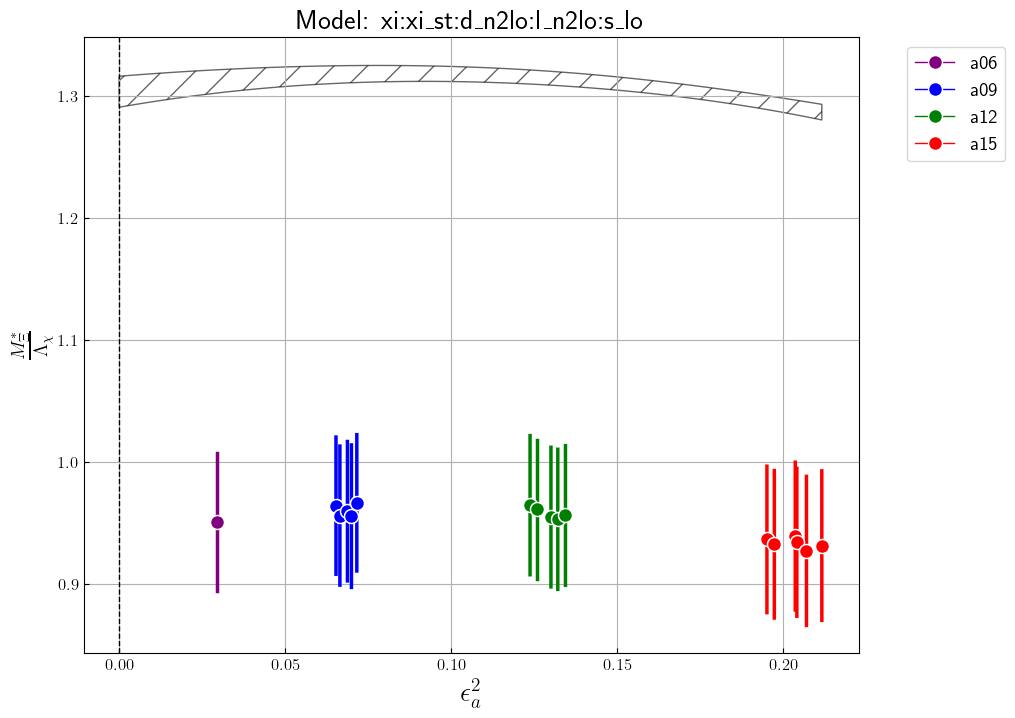

In [ ]:
reload(i_o)
reload(xfa)
reload(fit)

units_list = ['fpi']
discard_cov_opt = [True,False] # this option either retains the correlations between the pseudoscalars (scale setting params) or removes them # 
model_data = {}
test_mdl_key = 'xi:xi_st:d_n2lo:l_lo:s_lo'

for unit in units_list:
    data, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=False,decorr_scale=None)
    
    _model_info = xi_models[test_mdl_key].copy()
    _model_info['units'] = unit
    updated_mdl_key = i_o.update_model_key_name(test_mdl_key, unit)
# print(f"Processing: {updated_mdl_key}")  
    for dc in discard_cov_opt:
        xfa_instance = xfa.Xpt_Fit_Analysis(data=data,
                                        prior=new_prior,
                                        model_info=_model_info,
                                        phys_pt_data=phys_point_data,
                                        units=unit,
                                        extrapolate=True,
                                        discard_cov=dc,
                                        verbose=False,
                                        svd_test=False,
                                        svd_tol=None)
        config_key = f"{updated_mdl_key}_discardcov-{dc}"
        print(xfa_instance.fit.y)
        print(xfa_instance.shift_latt_to_phys(phys_params=['eps2_a','d_eps2_s','lam_chi','m_p'], observable='xi'))
        model_data[config_key] = xfa_instance 
        print('\n')
        print('extrapolation as fcn of pion mass')
        xfa_instance.plot_params_fit(param='epi',observable='xi',eps=True)
        xfa_instance.plot_params_fit(param='epi',observable='xi_st',eps=True)
        xfa_instance.plot_params_fit(param='a',observable='xi',eps=True)
        xfa_instance.plot_params_fit(param='a',observable='xi_st',eps=True)


        print('extrapolation as fcn of lattice spacing') 


# Print the results
for key, value in model_data.items():
    # Extract the unit from the key assuming the unit was appended to the original key.
    unit_from_info = value.model_info['units']
    print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
    print(key)
    print(value)
    # print("-" * 80)


### plots of extrapolation as a function of the pion mass ($\epsilon_{\pi}$) and lattice spacing ($\epsilon_a^2$) ###

Results for fitting in phys units:
xi:xi_st:d_n2lo:l_lo_phys_discardcov-True

---
Extrapolation:
Particle: xi
mass: 1346(17) [PDG: 1315(20)]
---
Particle: xi_st
mass: 1550(25) [PDG: 1532(32)]
---

Error Budget:
xi
  stat    100.0%
  disc     2.2%
  chiral   0.2%
  pp       0.0%
xi_st
  stat    100.0%
  disc     1.7%
  chiral   0.4%
  pp       0.0%
Least Square Fit:
  chi2/dof [dof] = 0.36 [34]    Q = 1    logGBF = -152.1

Parameters:
       m_{xi,0}       1323 (19)      [    1100 (400) ]  
         s_{xi}       1.44 (17)      [     0.0 (2.0) ]  
         S_{xi}     -2e-16 +- 2      [     0.0 (2.0) ]  
       d_{xi,a}      -0.68 (18)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.88 (67)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.7 (1.2)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1526 (27)      [    1300 (400) ]  
     s_{xi,bar}       1.55 (23)      [     0.0 (2.0) ]  
     S_{xi,bar}     -5e-17 +- 2      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.06 (23)      [     0.0 (2

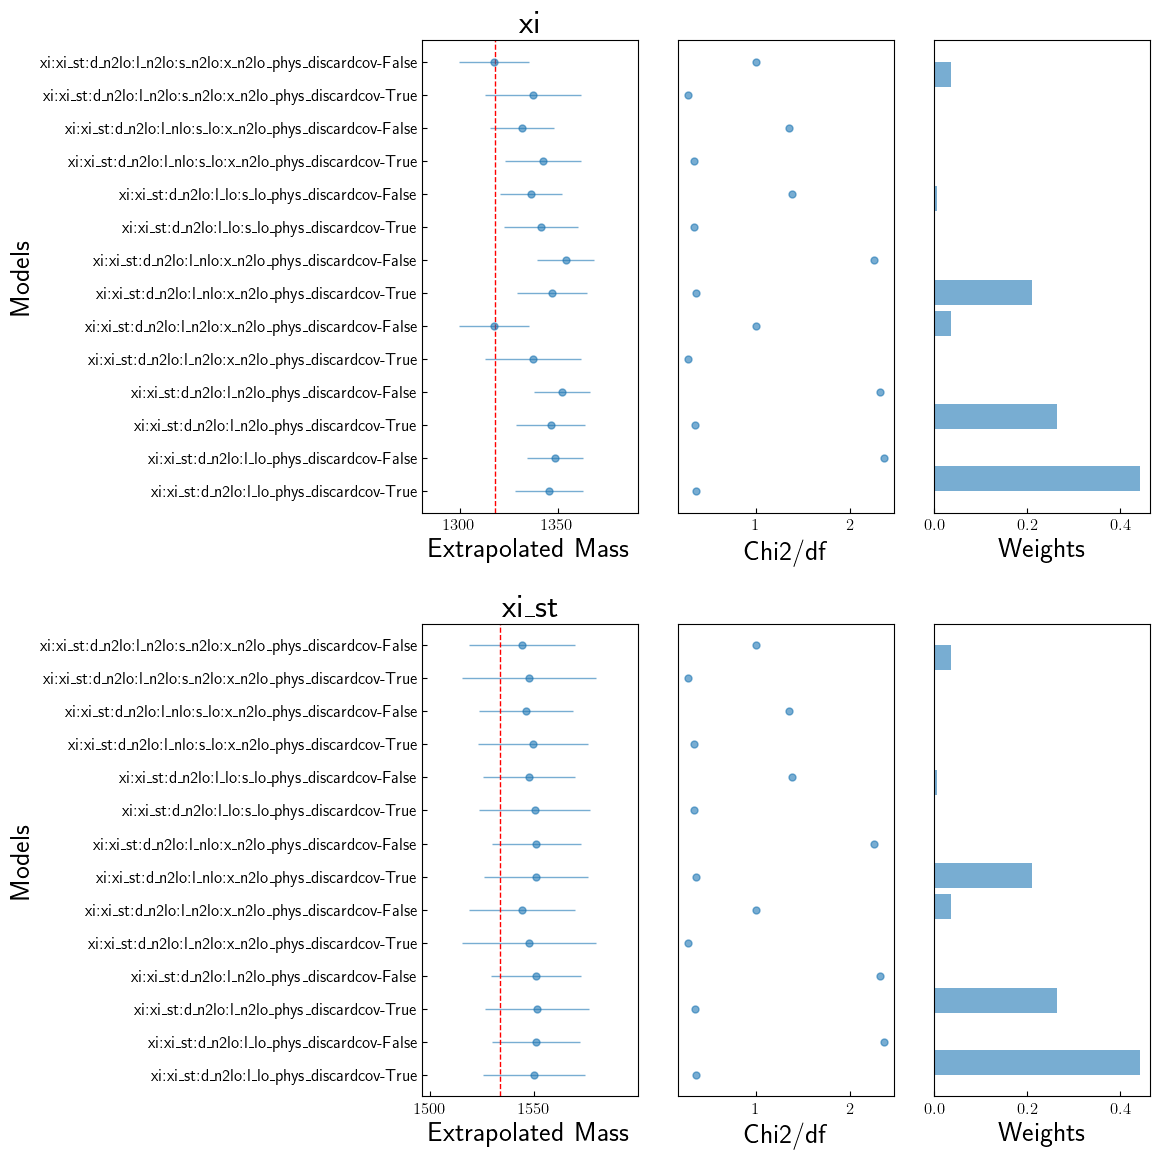

In [ ]:
phys_all = compare.run_analysis(units='phys',strange='2',compare_models=True,verbose=True)

{
    'xi':
    array([1411(13), 1283(11), 1320(11), 1372(11), 1389(11), 1412(11),
           1272.7(9.1), 1283.7(9.5), 1319.7(9.3), 1336.9(9.6), 1359.0(9.7),
           1259.3(8.4), 1258.8(8.4), 1295.5(8.5), 1289.3(8.9), 1303.4(9.6),
           1328.8(9.6)], dtype=object),
    'xi_st':
    array([1644(18), 1528(15), 1565(19), 1621(20), 1632(26), 1673(14),
           1537(12), 1557(11), 1582(13), 1600(14), 1624(13), 1529(11),
           1520(13), 1559(10), 1556(11), 1556(13), 1585(13)], dtype=object),
}
1411(13) latt
1406.4(8.9) fit
1382(52) phys
1283(11) latt
1294.6(7.6) fit
1342(19) phys
1320(11) latt
1323.0(5.6) fit
1355(21) phys
1372(11) latt
1364.7(4.4) fit
1372(39) phys
1389(11) latt
1386.8(4.8) fit
1380(49) phys
1412(11) latt
1417.1(7.0) fit
1392(65) phys
1272.7(9.1) latt
1264.4(5.3) fit
1342(19) phys
1283.7(9.5) latt
1285.0(4.8) fit
1349(18) phys
1319.7(9.3) latt
1317.8(4.5) fit
1363(29) phys
1336.9(9.6) latt
1337.6(4.6) fit
1372(39) phys
1359.0(9.7) latt
1361.9(5.8) fit
1382(5

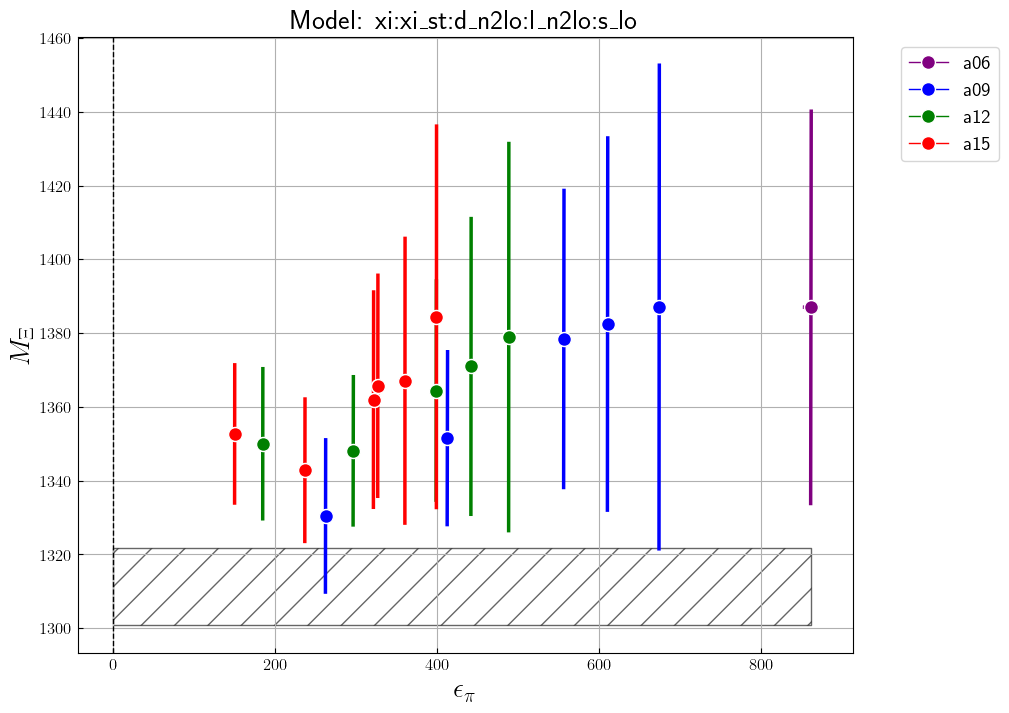

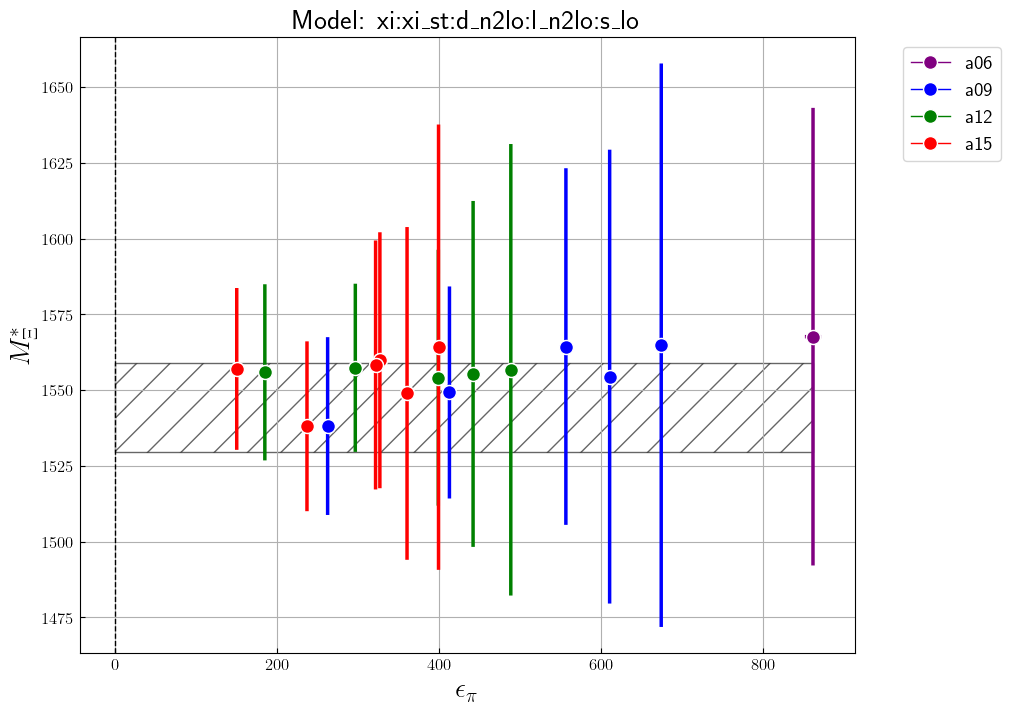

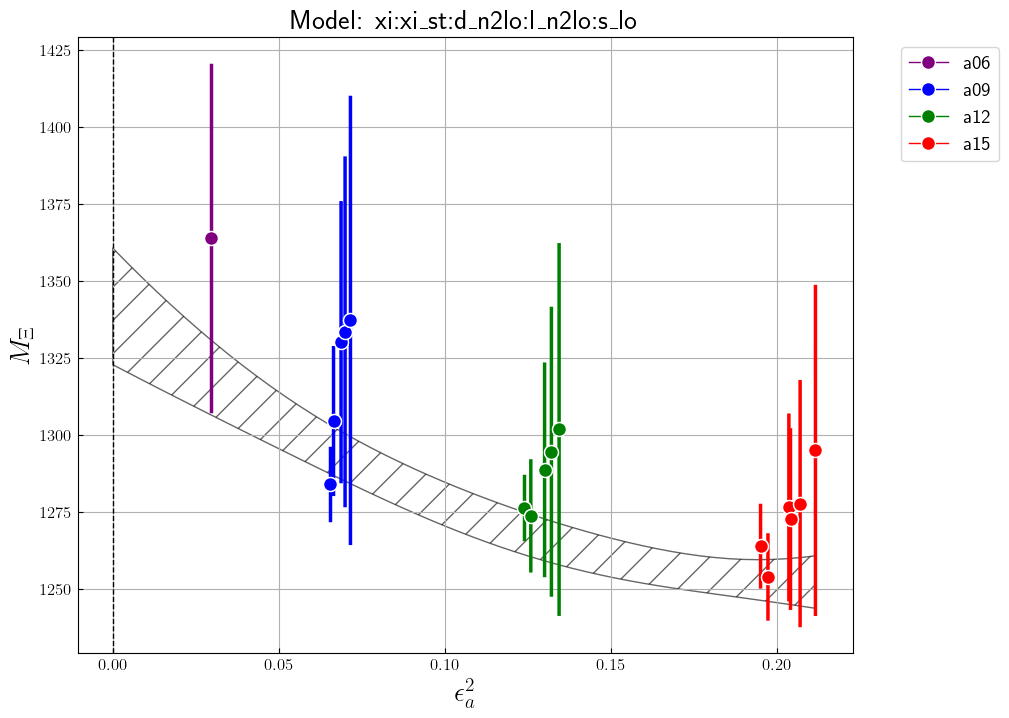

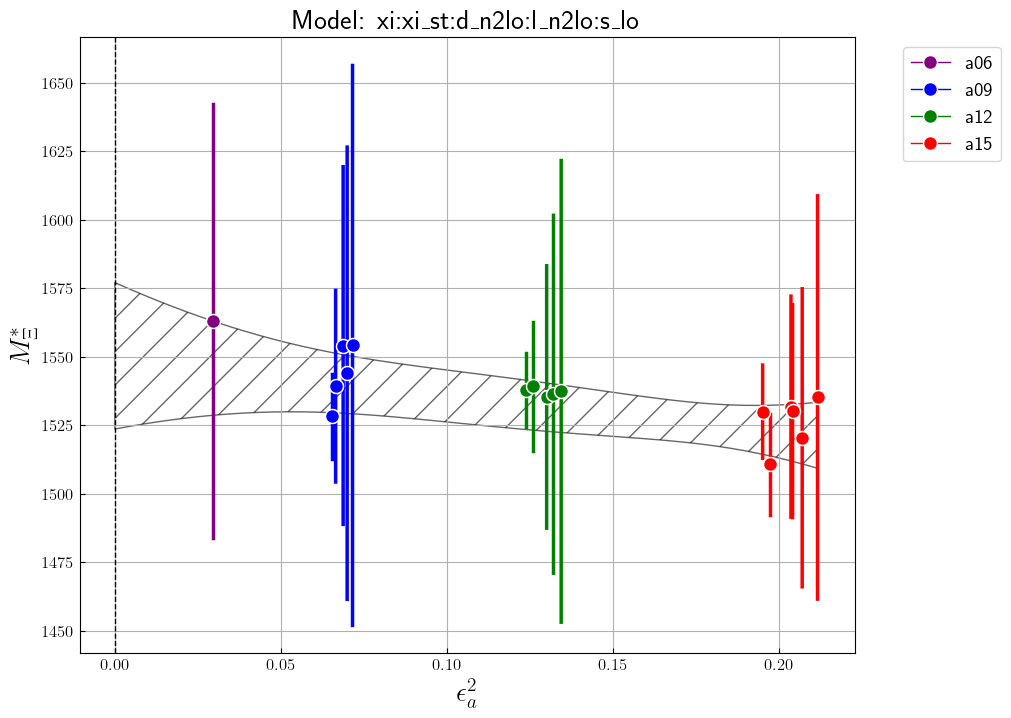

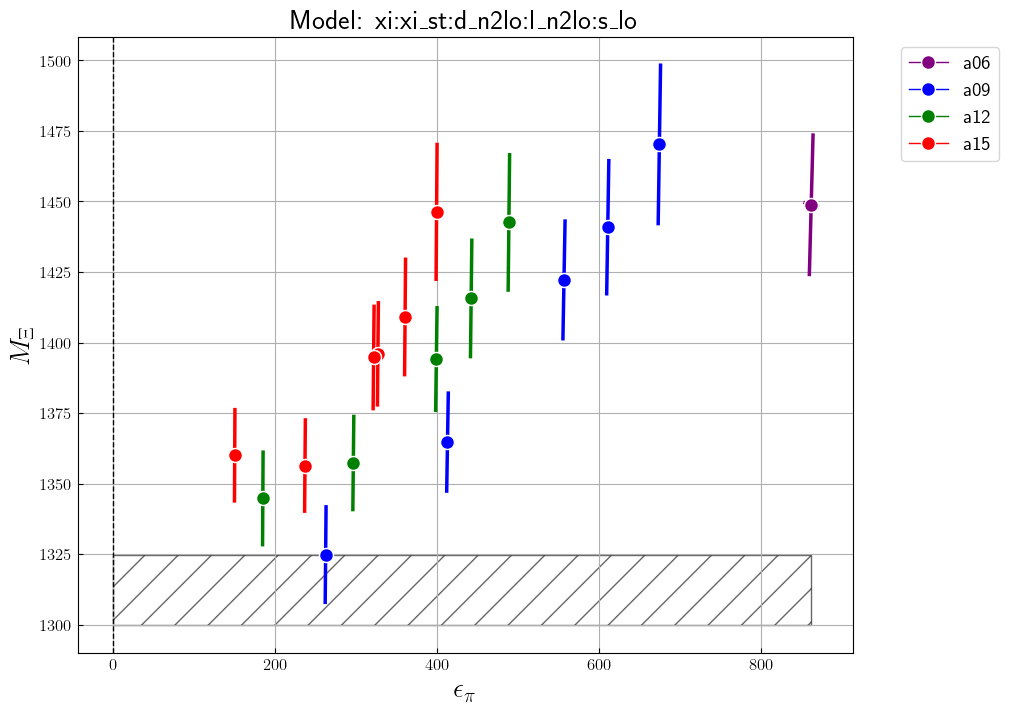

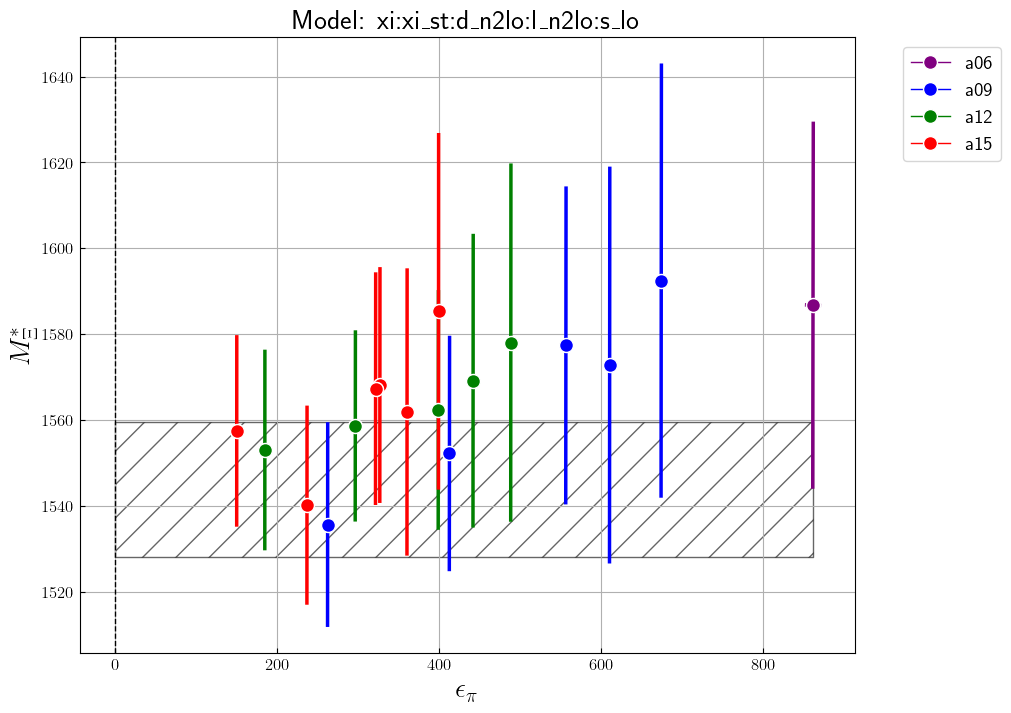

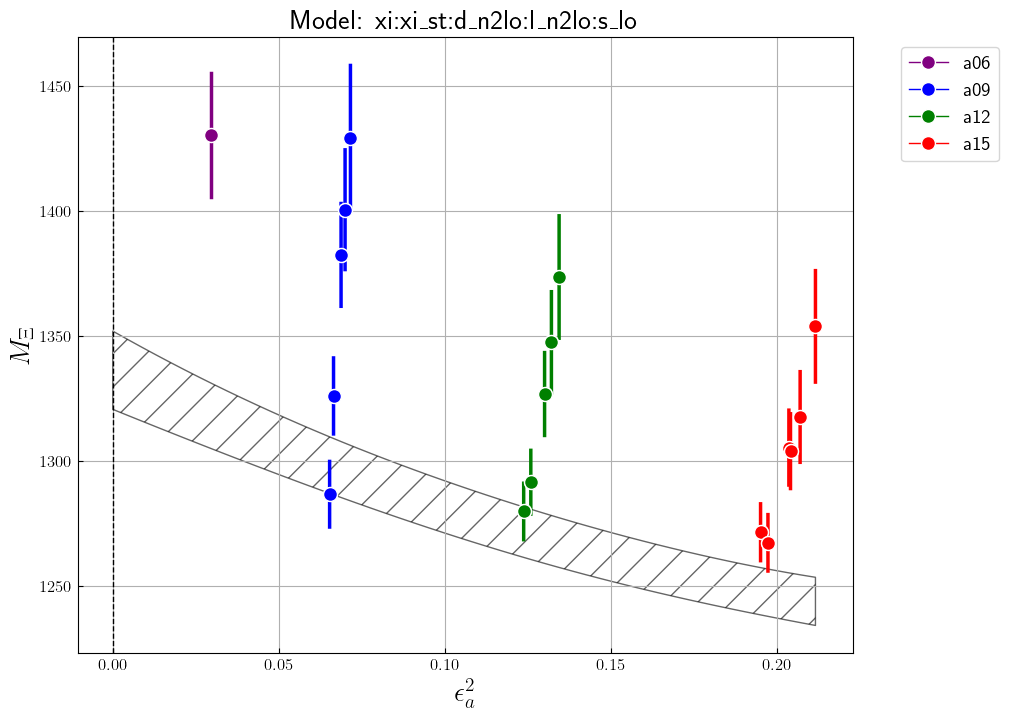

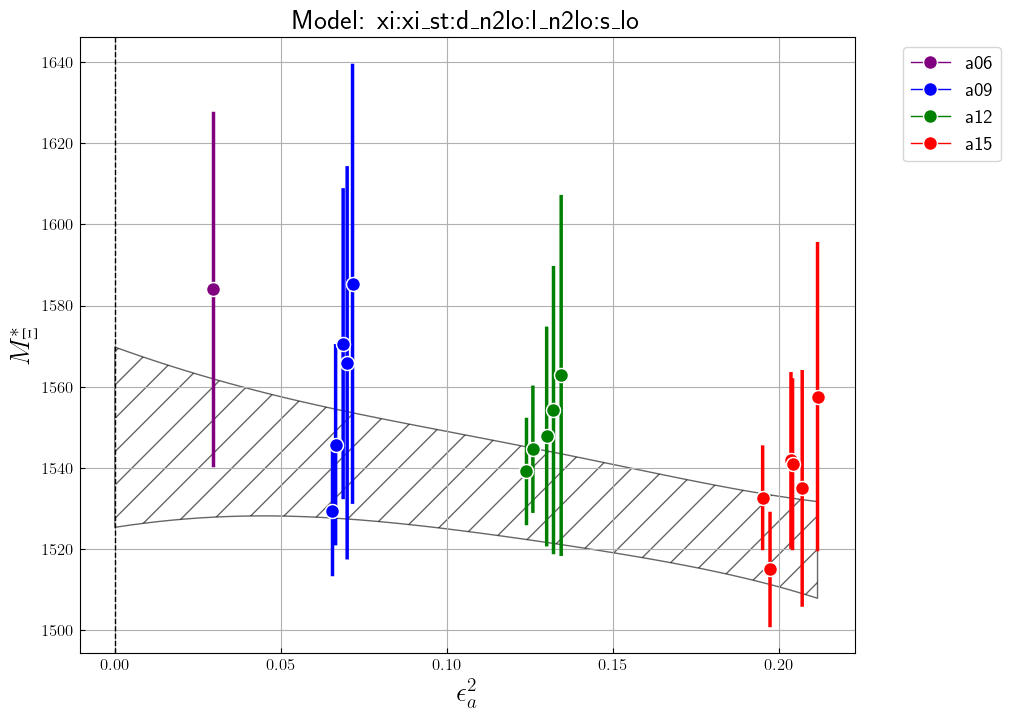

In [ ]:
reload(i_o)
reload(xfa)
reload(fit)

units_list = ['phys']
discard_cov_opt = [True,False] # this option either retains the correlations between the pseudoscalars (scale setting params) or removes them # 
model_data = {}
test_mdl_key = 'xi:xi_st:d_n2lo:l_lo:s_lo'

for unit in units_list:
    data, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=False,decorr_scale=None)
    
    _model_info = xi_models[test_mdl_key].copy()
    _model_info['units'] = unit
    updated_mdl_key = i_o.update_model_key_name(test_mdl_key, unit)
# print(f"Processing: {updated_mdl_key}")  
    for dc in discard_cov_opt:
        xfa_instance = xfa.Xpt_Fit_Analysis(data=data,
                                        prior=new_prior,
                                        model_info=_model_info,
                                        phys_pt_data=phys_point_data,
                                        units=unit,
                                        extrapolate=True,
                                        discard_cov=dc,
                                        verbose=False,
                                        svd_test=False,
                                        svd_tol=None)
        config_key = f"{updated_mdl_key}_discardcov-{dc}"
        print(xfa_instance.fit.y)
        print(xfa_instance.shift_latt_to_phys(phys_params=['eps2_a','d_eps2_s','lam_chi','m_pi'], observable='xi',debug=True))
        model_data[config_key] = xfa_instance 
        print('\n')
        print('extrapolation as fcn of pion mass')
        xfa_instance.plot_params_fit(param='epi',observable='xi',eps=False)
        xfa_instance.plot_params_fit(param='epi',observable='xi_st',eps=False)
        xfa_instance.plot_params_fit(param='a',observable='xi',eps=False)
        xfa_instance.plot_params_fit(param='a',observable='xi_st',eps=False)


        print('extrapolation as fcn of lattice spacing') 


# Print the results
for key, value in model_data.items():
    # Extract the unit from the key assuming the unit was appended to the original key.
    unit_from_info = value.model_info['units']
    print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
    print(key)
    print(value)
    # print("-" * 80)


2. Fit $M_H$ in physical units 
    - 2a. Work in MeV from outset 
    - 2b. Work in lattice units then convert to MeV at time of extrapolation 


{'m_xi': array([1411(13), 1283(11), 1320(11), 1372(11), 1389(11), 1412(11),
       1272.7(9.1), 1283.7(9.5), 1319.7(9.3), 1336.9(9.6), 1359.0(9.7),
       1259.3(8.4), 1258.8(8.4), 1295.5(8.5), 1289.3(8.9), 1303.4(9.6),
       1328.8(9.6)], dtype=object), 'm_xi_st': array([1644(18), 1528(15), 1565(19), 1621(20), 1632(26), 1673(14),
       1537(12), 1557(11), 1582(13), 1600(14), 1624(13), 1529(11),
       1520(13), 1559(10), 1556(11), 1556(13), 1585(13)], dtype=object), 'm_pi': array([327.9(2.8), 134.6(1.0), 221.6(1.7), 318.7(2.5), 357.4(2.8),
       409.7(3.2), 132.39(95), 219.5(1.5), 308.4(2.1), 349.8(2.4),
       398.3(2.7), 134.80(88), 216.9(1.4), 310.2(2.1), 307.1(2.0),
       348.1(2.3), 397.7(2.6)], dtype=object), 'm_k': array([562.3(4.9), 494.3(3.8), 517.4(4.0), 545.4(4.2), 558.8(4.3),
       577.4(4.4), 494.3(3.4), 507.8(3.5), 530.4(3.7), 545.6(3.8),
       561.8(3.9), 508.5(3.3), 507.8(3.3), 531.1(3.5), 530.0(3.5),
       543.6(3.6), 561.0(3.7)], dtype=object), 'lam_chi': arra

KeyboardInterrupt: 

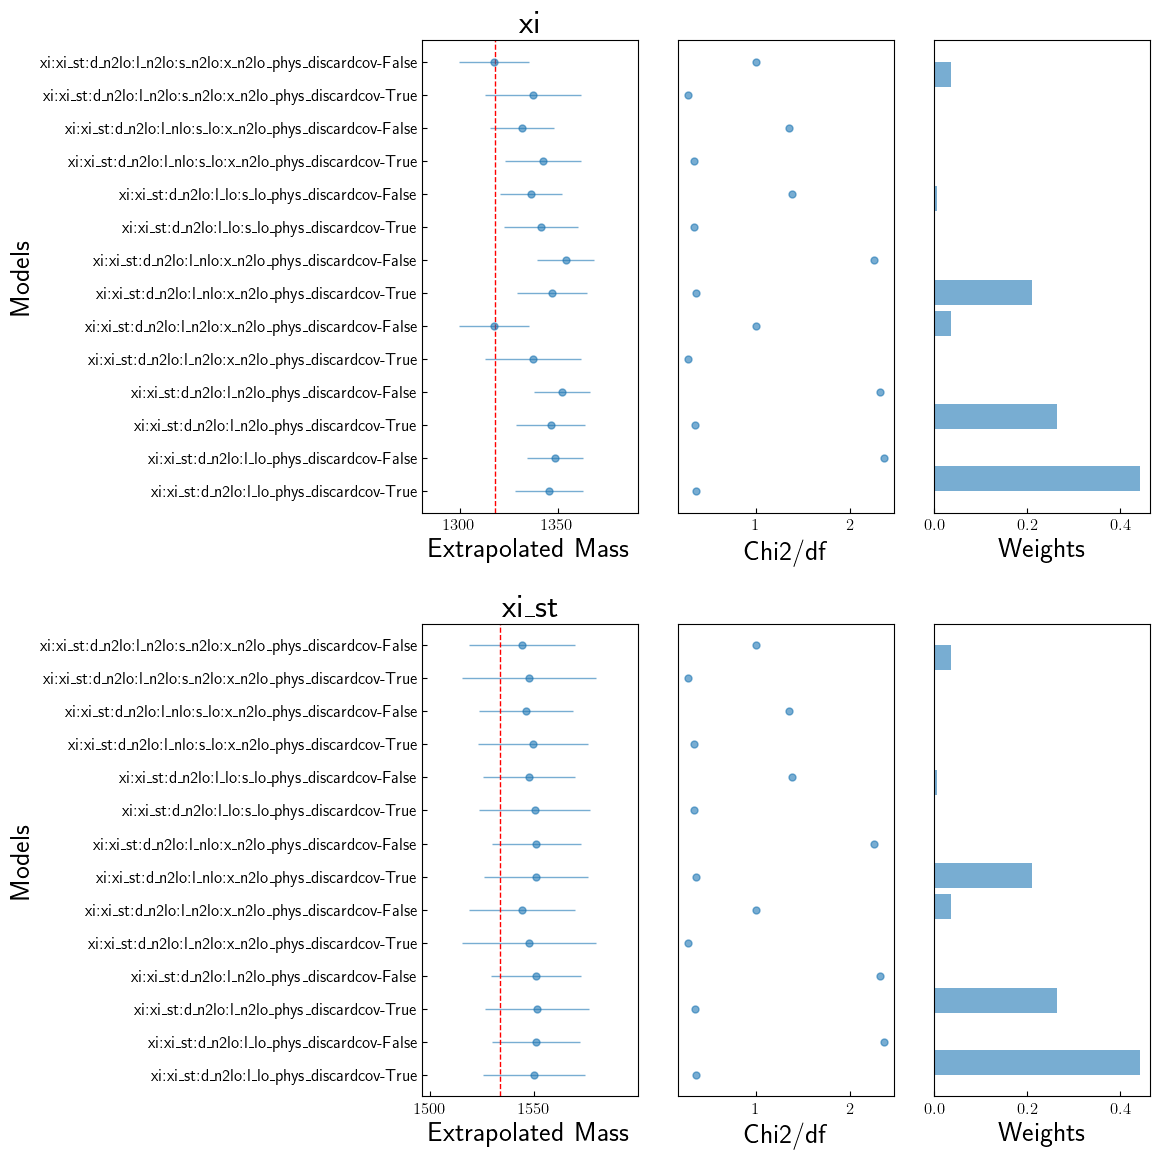

<Figure size 1000x1000 with 0 Axes>

In [ ]:
reload(xfa)
units_list = ['phys']
decorrelate_scale_opts = [True,False]
discard_cov_opt = [True,False] # this option either retains the correlations between the pseudoscalars (scale setting params) or removes them # 
model_data = {}
for unit in units_list:
    # for ds in decorrelate_scale_opts:
        data, new_prior, phys_point_data = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=False,decorr_scale=None)
        print(data)
    
        for mdl_key in xi_models:
            _model_info = xi_models[mdl_key].copy()
            _model_info['units'] = unit
            updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
        # print(f"Processing: {updated_mdl_key}")  
            for dc in discard_cov_opt:
                xfa_instance = xfa.Xpt_Fit_Analysis(data=data,
                                                prior=new_prior,
                                                model_info=_model_info,
                                                phys_pt_data=phys_point_data,
                                                units=unit,
                                                extrapolate=True,
                                                discard_cov=dc,
                                                verbose=False,
                                                svd_test=False,
                                                svd_tol=None)
                config_key = f"{updated_mdl_key}_discardcov-{dc}"
            
                model_data[config_key] = xfa_instance  

# print(model_data['xi:xi_st:d_n2lo:l_lo_fpi'])

# Print the results
for key, value in model_data.items():
    # Extract the unit from the key assuming the unit was appended to the original key.
    unit_from_info = value.model_info['units']
    # print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
    # print(key)
    # print(value)
    # print("-" * 80)

reload(compare)
compare_ = compare.ModelComparsion(models=model_data,compare_type='phys',units='phys')
compare_.compare_models(particles=['xi','xi_st'])
mdl_avg = compare_.model_average(particles=['xi','xi_st'])
print(mdl_avg)
compare_.model_plots(system='xi')

In [ ]:
reload(xfa)
units_list = ['phys']
decorrelate_scale_opts = [True,False]
discard_cov_opt = [True,False] # this option either retains the correlations between the pseudoscalars (scale setting params) or removes them # 
model_data = {}
for unit in units_list:
    data_mev, new_prior_mev, phys_point_data_mev = i_o.get_data_and_prior_for_unit(unit,system='lam',scheme='w0_org',convert_data=True)
    
    # for mdl_key in xi_models:
    _model_info = lam_sigma_models['lam:sigma:sigma_st:l_n2lo:d_n2lo:s_n2lo:x_n2lo'].copy()
    _model_info['units'] = unit
    # updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
        # print(f"Processing: {updated_mdl_key}")  
    xfa_instance = xfa.Xpt_Fit_Analysis(data=data_mev,
                                            prior=new_prior_mev,
                                            model_info=_model_info,
                                            phys_pt_data=phys_point_data_mev,
                                            units=unit,
                                            extrapolate=True,
                                            discard_cov=True,
                                            verbose=False,
                                            svd_test=False,
                                            svd_tol=None)
    print(xfa_instance)
xfa_instance.svd_analysis()        
    # model_data[updated_mdl_key] = xfa_instance  

TypeError: get_data_and_prior_for_unit() missing 1 required positional argument: 'decorr_scale'

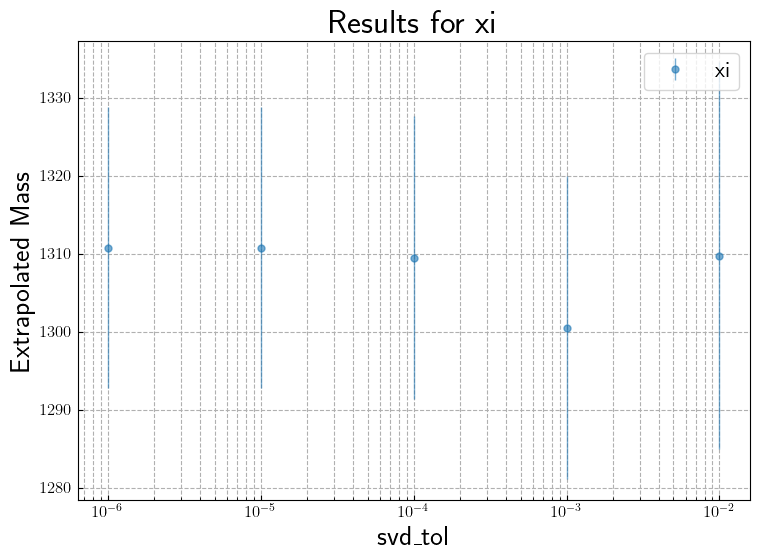

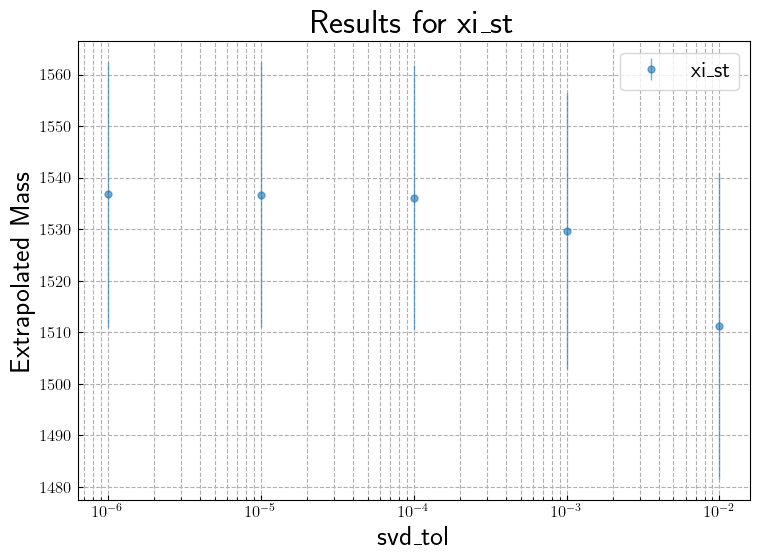

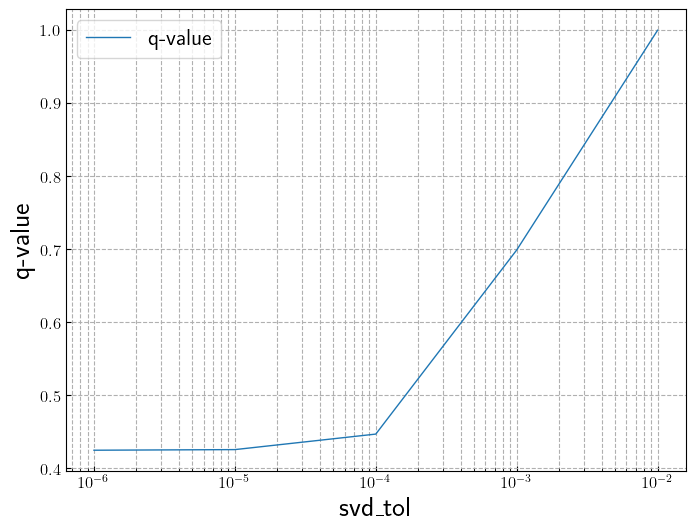

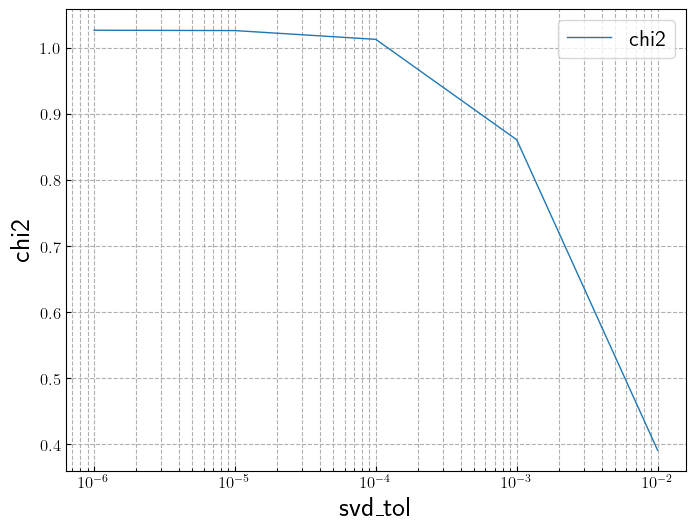

In [ ]:
reload(xfa)
units_list = ['phys']
decorrelate_scale_opts = [True,False]
model_data = {}

for unit in units_list:
    data_mev, new_prior_mev, phys_point_data_mev = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=True)
    
    # for mdl_key in xi_models:
    _model_info = xi_models['xi:xi_st:d_n2lo:l_n2lo:s_n2lo:x_n2lo'].copy()
    _model_info['units'] = unit
    # updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
        # print(f"Processing: {updated_mdl_key}")  

    xfa_instance = xfa.Xpt_Fit_Analysis(data=data_mev,
                                            prior=new_prior_mev,
                                            model_info=_model_info,
                                            phys_pt_data=phys_point_data_mev,
                                            units=unit,
                                            extrapolate=True,
                                            discard_cov=False,
                                            verbose=False,
                                            svd_test=False,
                                            svd_tol=None)
    xfa_instance.svd_analysis()        
    # model_data[updated_mdl_key] = xfa_instance  

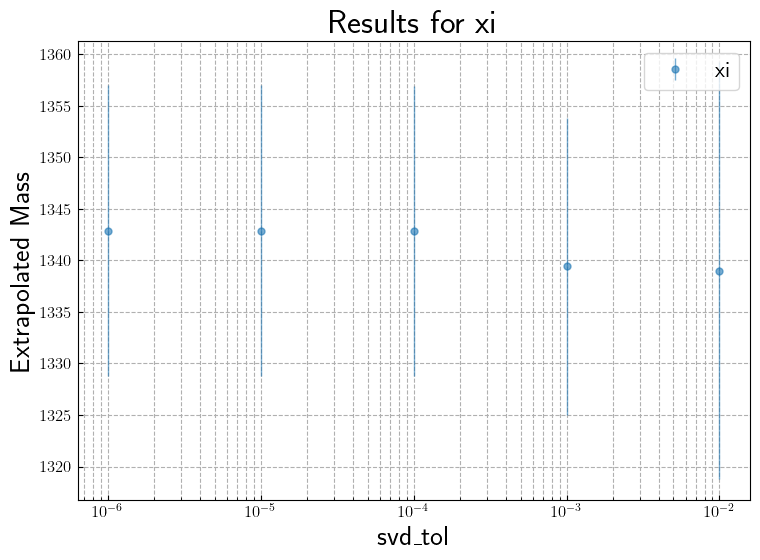

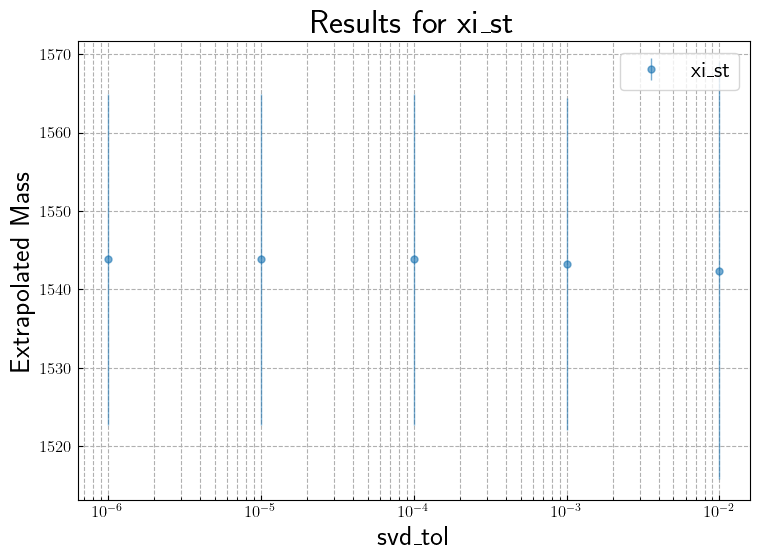

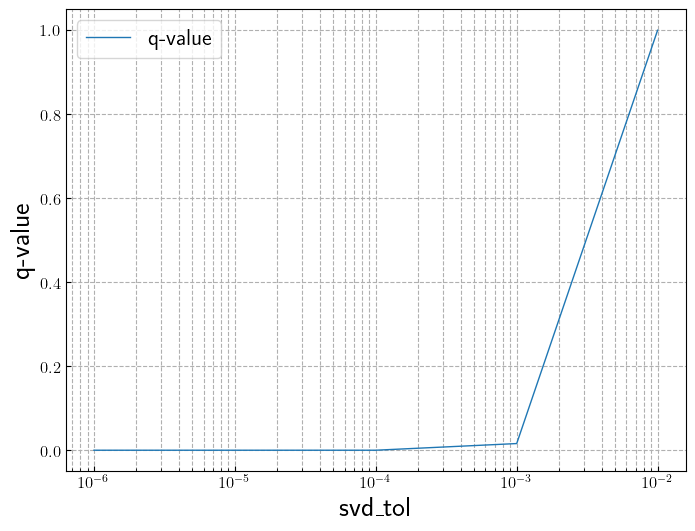

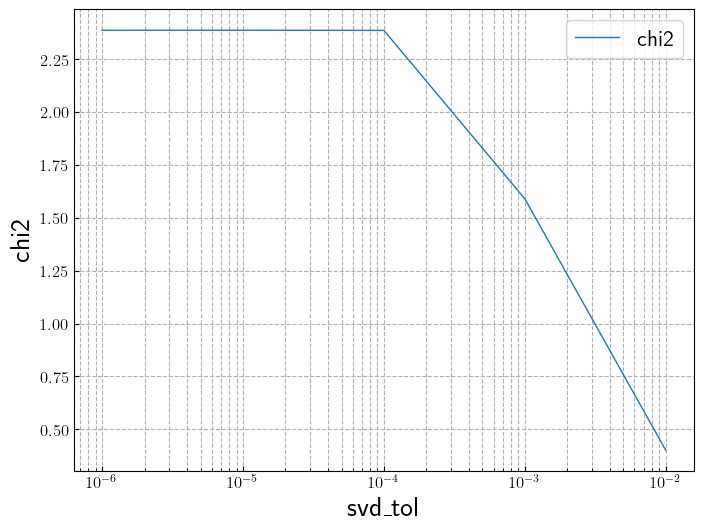

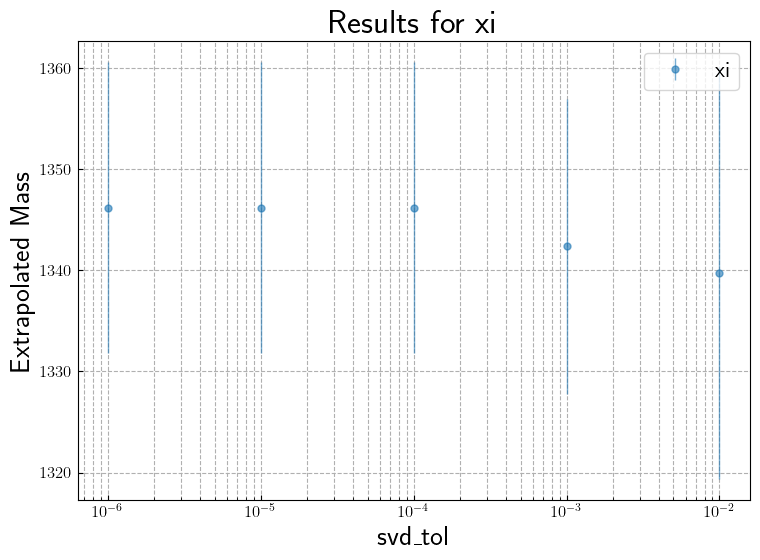

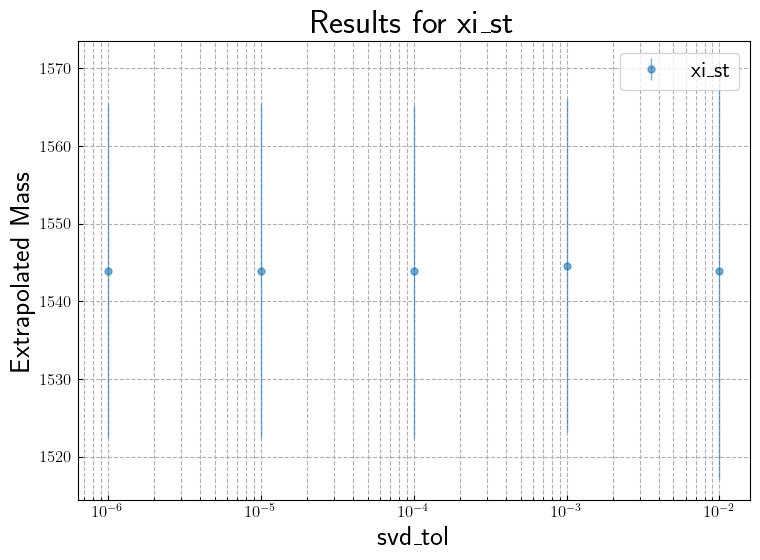

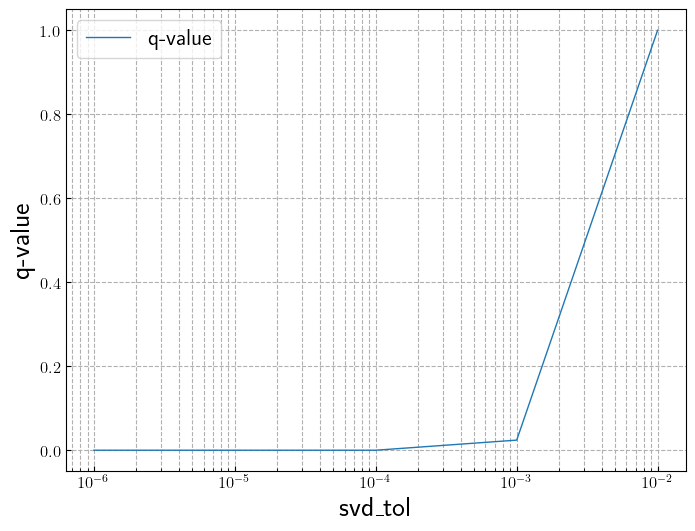

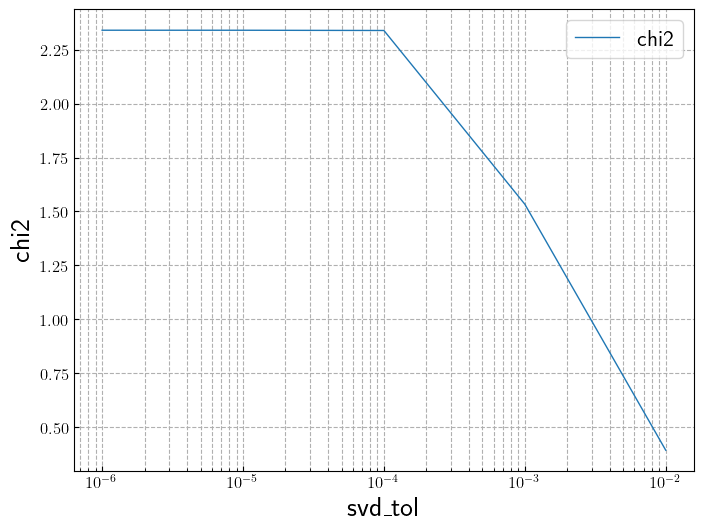

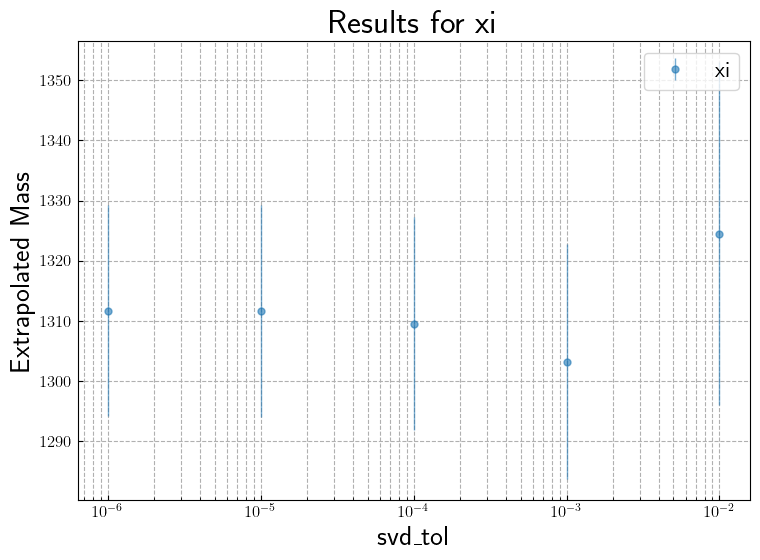

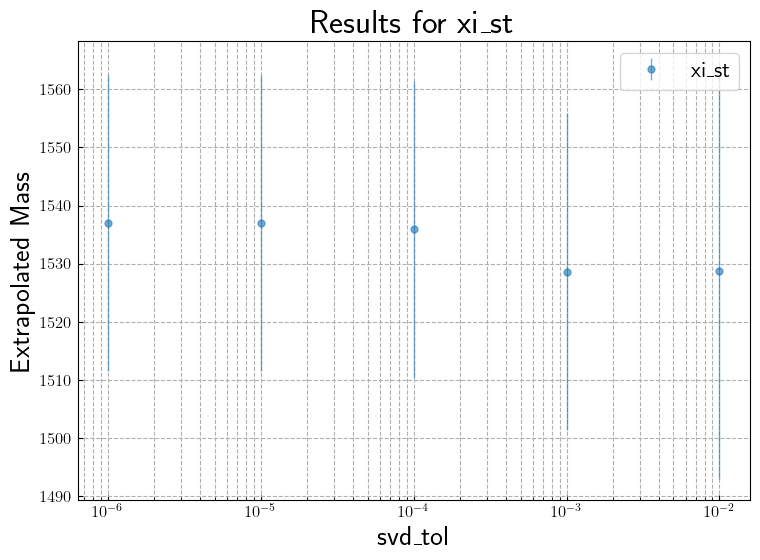

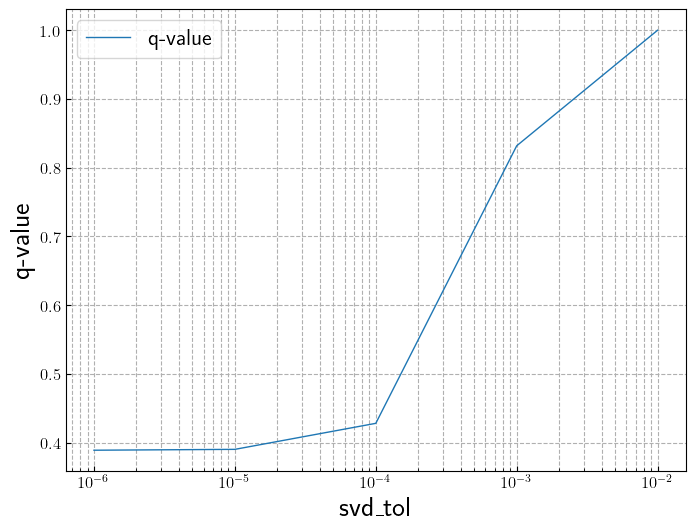

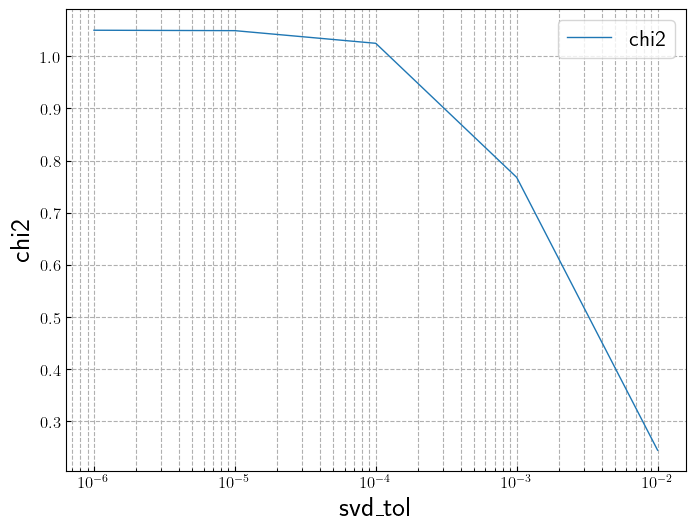

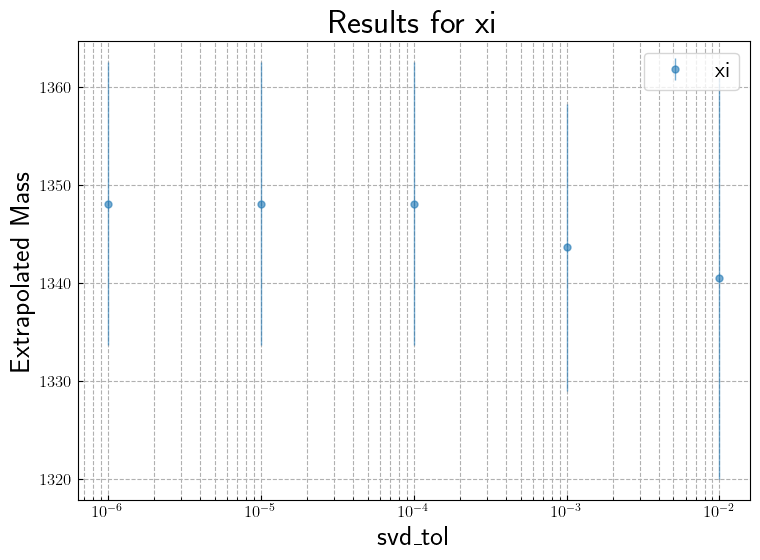

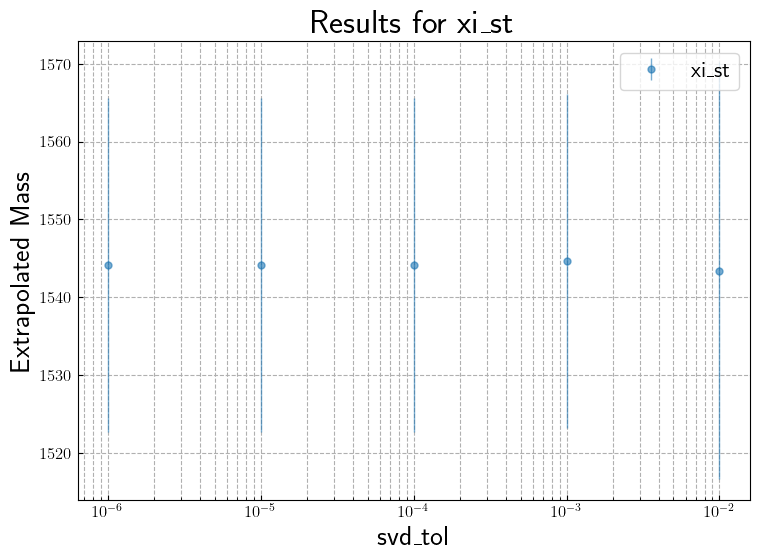

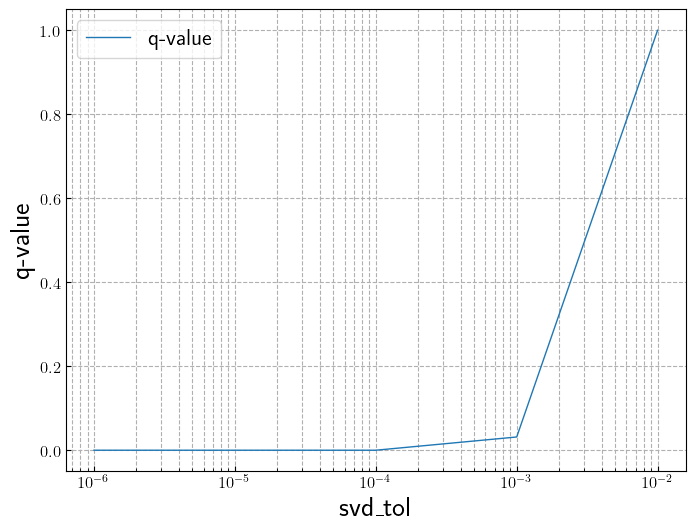

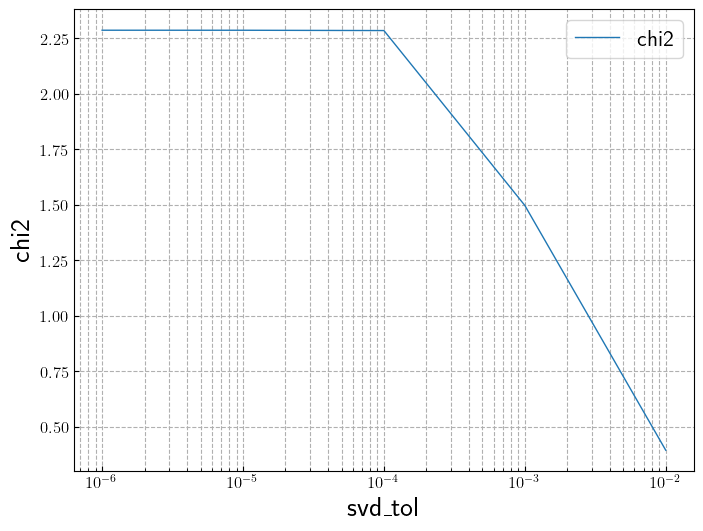

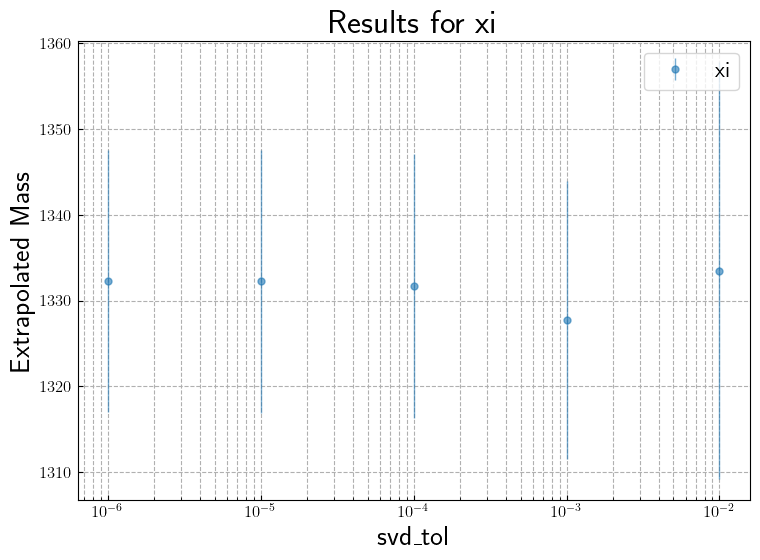

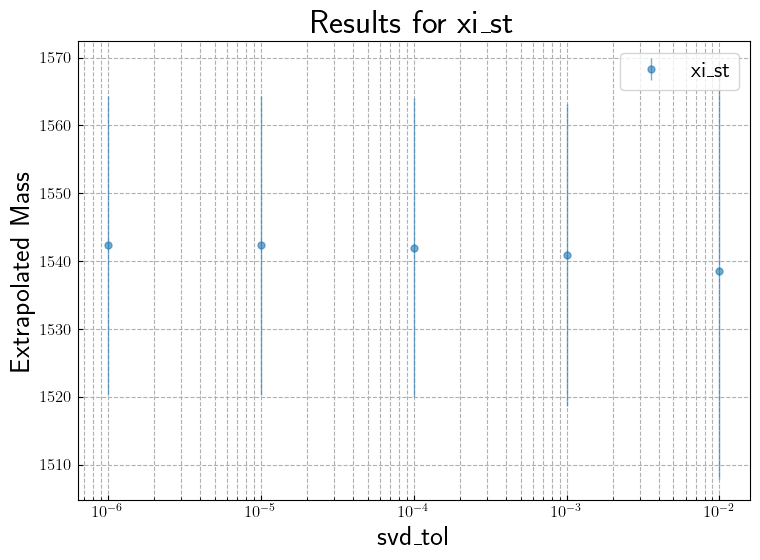

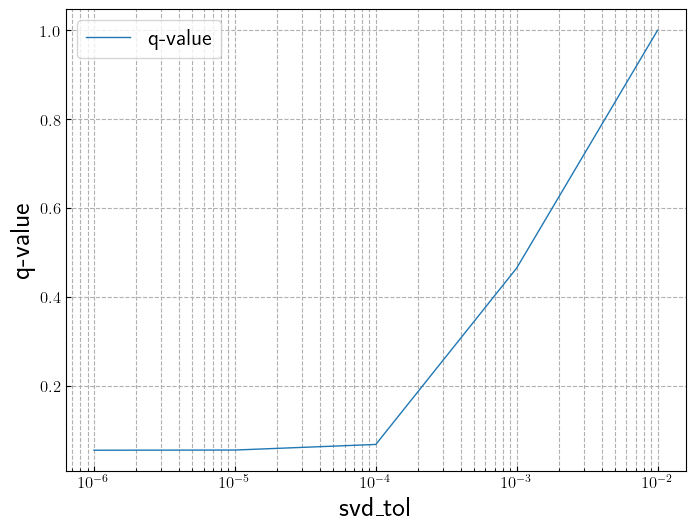

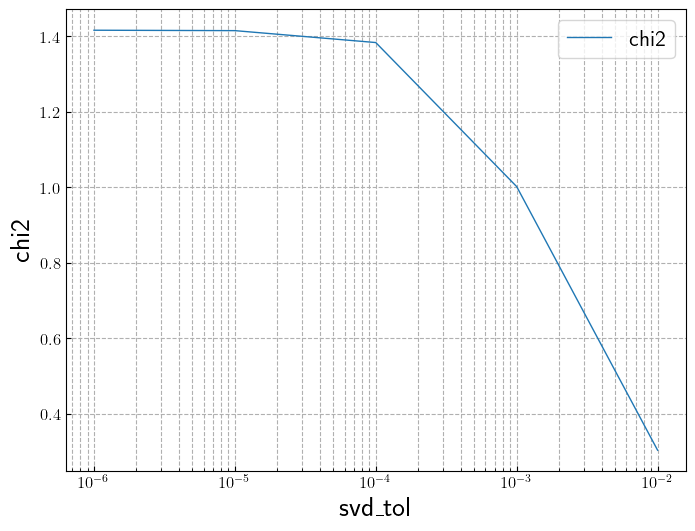

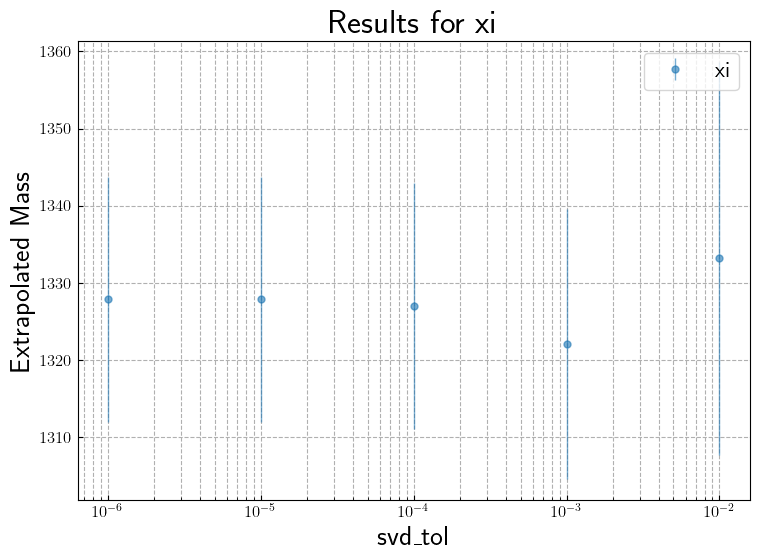

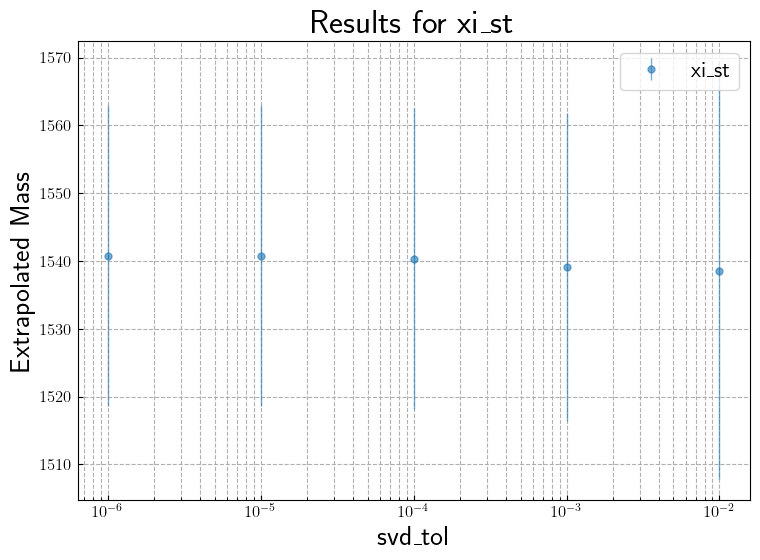

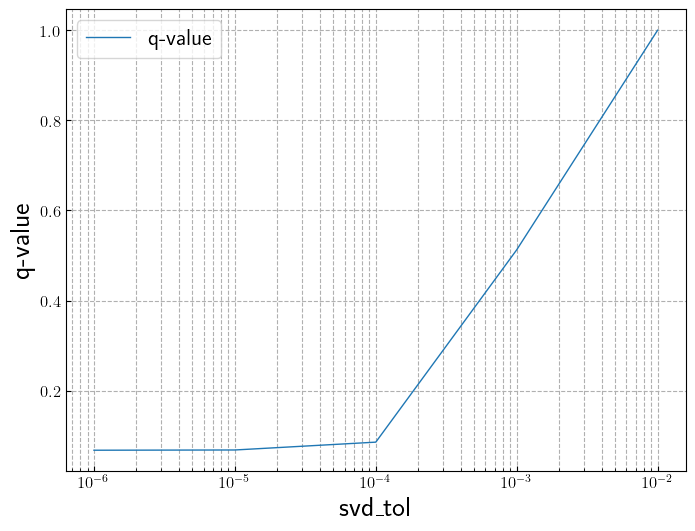

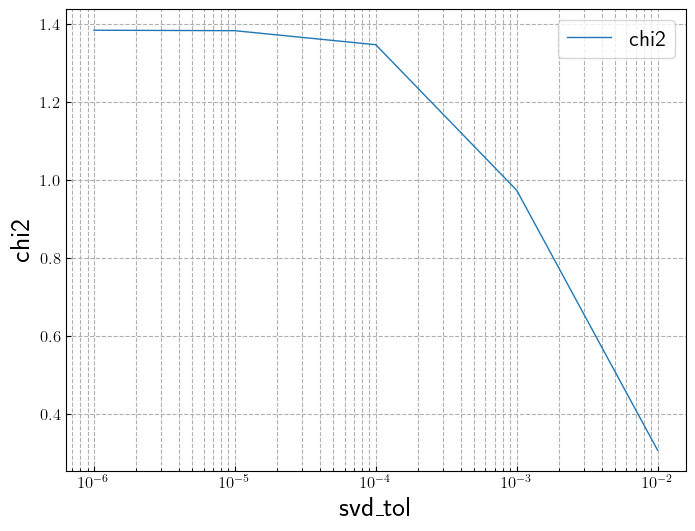

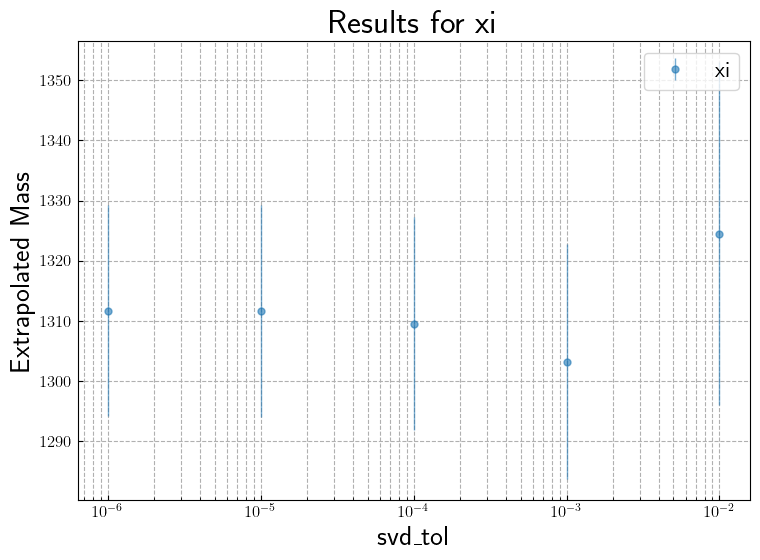

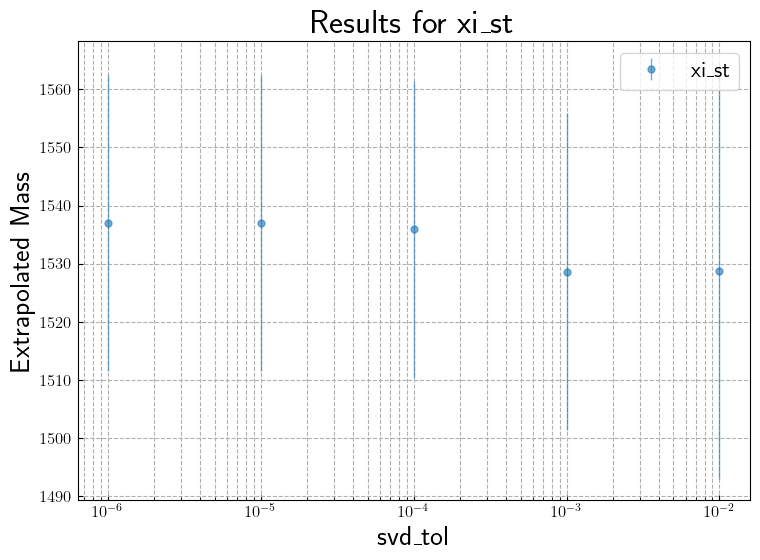

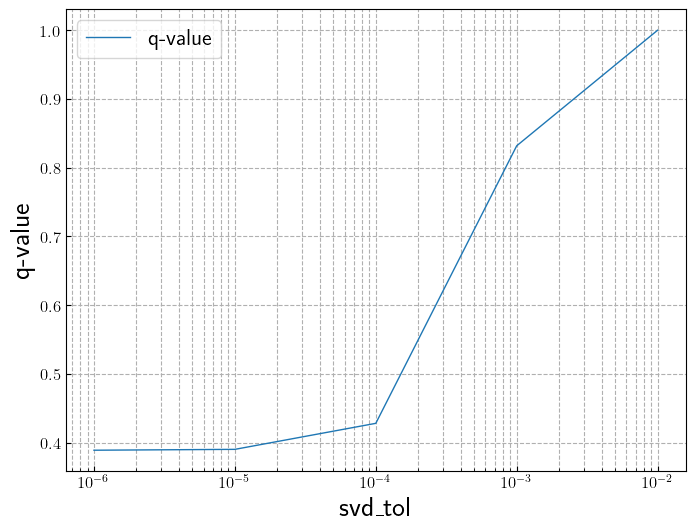

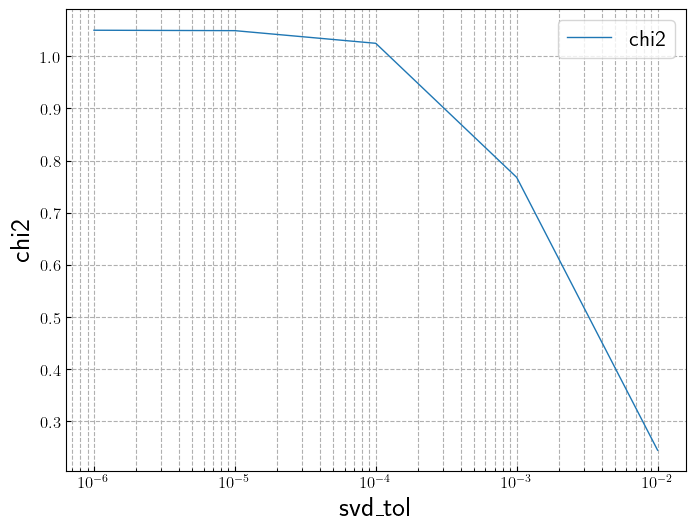

({'xi': 1338(59), 'xi_st': 1536(72)}, {'xi:xi_st:d_n2lo:l_lo_phys': 0.40888276463968515, 'xi:xi_st:d_n2lo:l_n2lo_phys': 0.3456501582088226, 'xi:xi_st:d_n2lo:l_nlo:x_n2lo_phys': 0.245145027331081, 'xi:xi_st:d_n2lo:l_n2lo:x_n2lo_phys': 0.0001596965972054939, 'xi:xi_st:d_n2lo:l_n2lo:s_n2lo:x_n2lo_phys': 0.000159696564902123, 'xi:xi_st:d_n2lo:l_lo:s_lo_phys': 2.256184638067321e-06, 'xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo_phys': 4.004736654884069e-07})


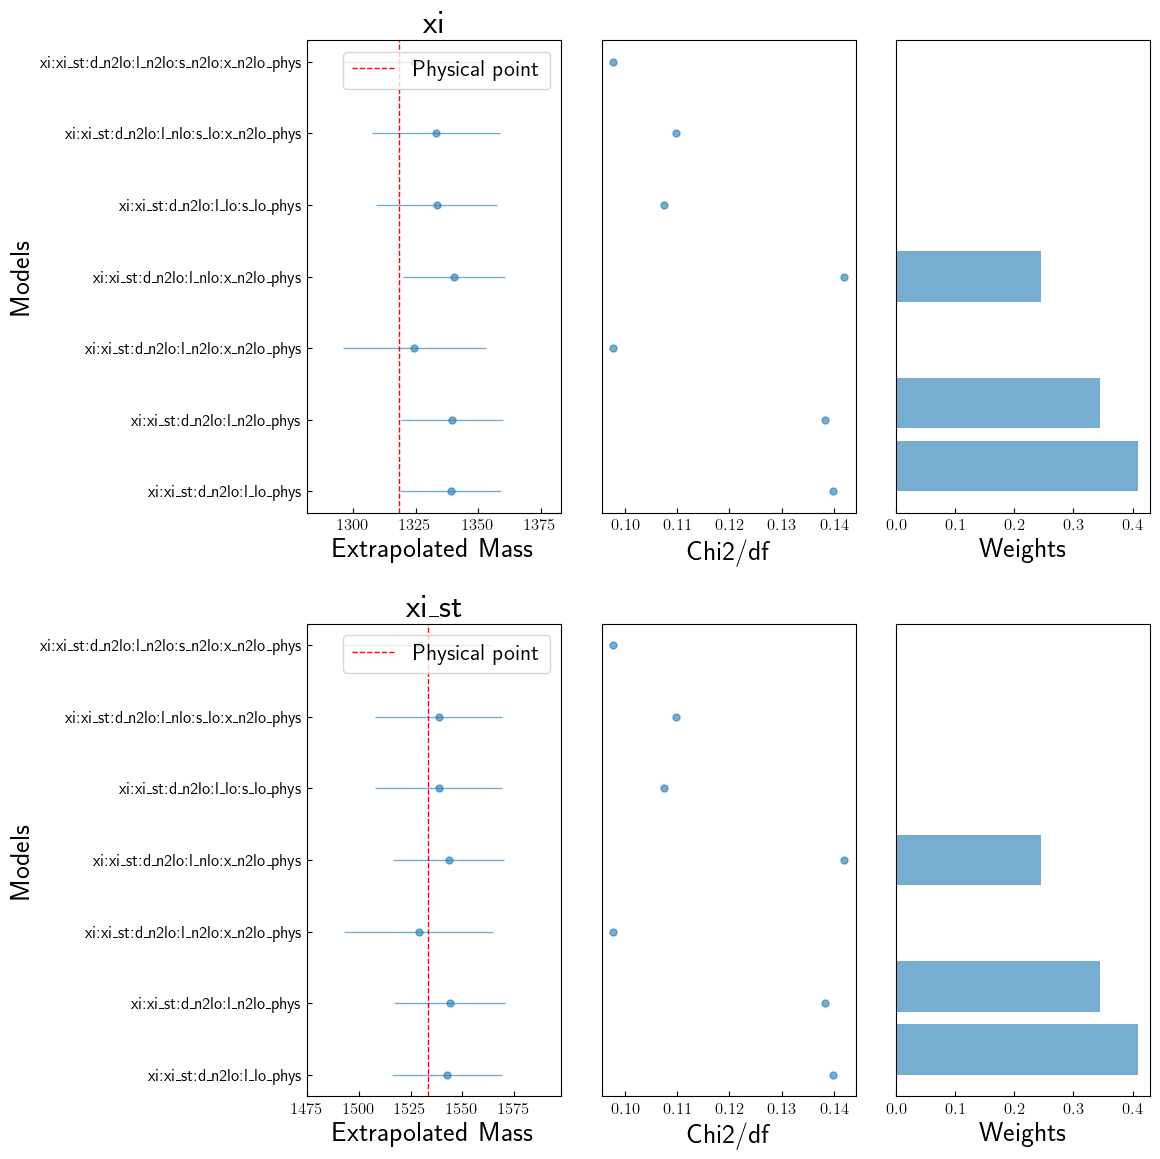

In [ ]:
reload(i_o)

units_list = ['phys']
decorrelate_scale_opts = [True,False]
model_data = {}

for unit in units_list:
    data_mev, new_prior_mev, phys_point_data_mev = i_o.get_data_and_prior_for_unit(unit,system='xi',scheme='w0_imp',convert_data=True)
    
    for mdl_key in xi_models:
        _model_info = xi_models[mdl_key].copy()
        _model_info['units'] = unit
        updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
        # print(f"Processing: {updated_mdl_key}")  

        xfa_instance = xfa.Xpt_Fit_Analysis(data=data_mev,
                                            prior=new_prior_mev,
                                            model_info=_model_info,
                                            phys_pt_data=phys_point_data_mev,
                                            units=unit,
                                            extrapolate=True,
                                            discard_cov=True,
                                            verbose=False,
                                            svd_test=False,
                                            svd_tol=0.06)
        xfa_instance.svd_analysis()        
        model_data[updated_mdl_key] = xfa_instance  

# print(model_data['xi:xi_st:d_n2lo:l_lo_fpi'])

# # Print the results
# for key, value in model_data.items():
#     # Extract the unit from the key assuming the unit was appended to the original key.
#     unit_from_info = value.model_info['units']
#     print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
#     print(value)
#     print("-" * 80)

reload(compare)
compare_ = compare.ModelComparsion(models=model_data,compare_type='phys',units='phys')
compare_.compare_models(particles=['xi','xi_st'])
mdl_avg = compare_.model_average(particles=['xi','xi_st'])
print(mdl_avg)
compare_.model_plots(system='xi')





## Fitting the $\Xi$ system in physical units, converting data to MeV before passing to fit function ##

In [ ]:
from importlib import reload 
reload(xfa)
reload(i_o)
reload(fit)
reload(priors)
units_list = ['lattice']
model_data_phys = {}

for unit in units_list:
    data_phys, new_prior_phys, phys_point_data_mev = i_o.get_data_and_prior_for_unit(unit='lattice',system='xi',scheme='w0_imp',convert_data=False)

    
    for mdl_key in xi_models:
        _model_info = xi_models[mdl_key].copy()
        _model_info['units'] = unit
        updated_mdl_key = i_o.update_model_key_name(mdl_key, unit)
        print(f"Processing: {updated_mdl_key}")  

        xfa_instance = xfa.Xpt_Fit_Analysis(data=data,
                                            prior=new_prior,
                                            model_info=_model_info,
                                            phys_pt_data=phys_point_data,
                                            units=unit,
                                            extrapolate=True,
                                            discard_cov=True,
                                            verbose=True,
                                            svd_test=False,
                                            svd_tol=None)
        print(xfa_instance.fit.p)
        
        model_data_phys[updated_mdl_key] = xfa_instance  

# # Print the results
for key, value in model_data_phys.items():
    # Extract the unit from the key assuming the unit was appended to the original key.
    unit_from_info = value.model_info['units']
    print(f"Results for {i_o.get_unit_description(unit_from_info)}:")
    print(value)
    print("-" * 80)

# reload(compare)
# compare_ = compare.ModelComparsion(models=model_data_phys,compare_type='phys',units='phys')
# compare_.compare_models(particles=['xi','xi_st'])
# mdl_avg = compare_.model_average(particles=['xi','xi_st'])
# print(mdl_avg)
# compare_.model_plots(system='xi')

KeyError: 'a_fm'

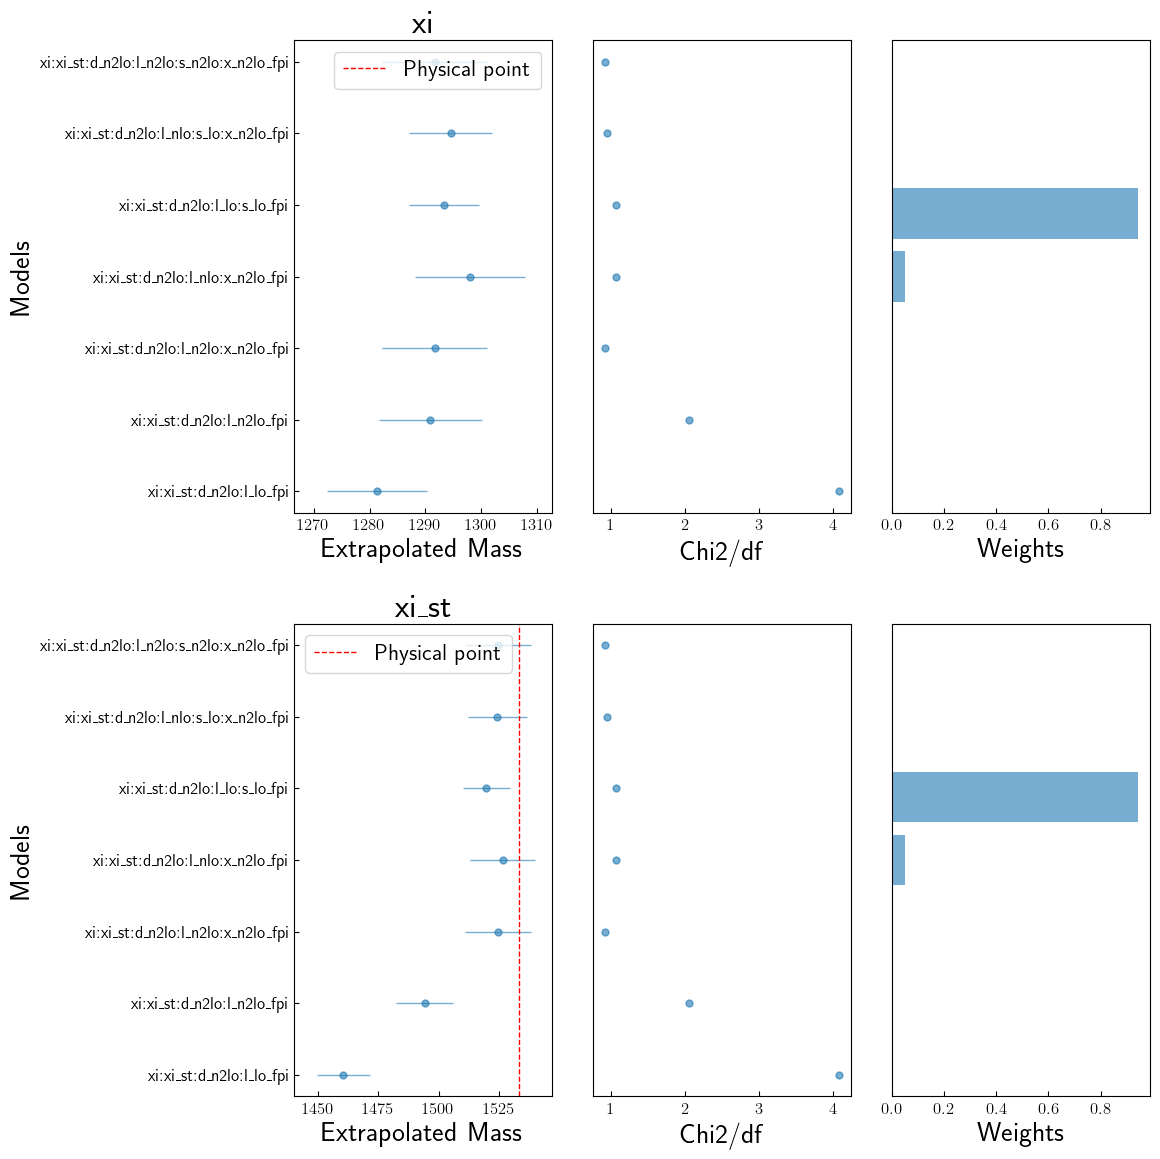

## $ \Lambda, \Sigma, \Sigma^*$ system ##

In [ ]:
reload(i_o)
input_output = i_o.InputOutput(units='phys',scheme='w0_org',system='lambda',convert_data=False)

# print(input_output.perform_svdcut())
data_test = input_output.perform_gvar_processing()

In [ ]:
reload(fit)
reload(i_o)
reload(xfa)
reload(compare)
test_model = 'lam:sigma:sigma_st:l_n2lo:d_n2lo:s_n2lo:x_n2lo_phys'

_model_info = lam_sigma_models[test_model]

xfa_instance = xfa.Xpt_Fit_Analysis(data=data_test,model_info=_model_info,
                                                extrapolate=True,discard_cov=True,verbose=True,svd_test=False,svd_tol=0.06)
print(xfa_instance)
# xfa_instance.svd_analysis()


# for mdl_key in lam_sigma_models:
#     _model_info = lam_sigma_models[mdl_key]
#     xfa_instance = xfa.Xpt_Fit_Analysis(model_info=_model_info,
#                                                 extrapolate=True,discard_cov=True,verbose=False,svd_test=False,svd_tol=0.06)
    
#     print(xfa_instance)
    
# lam_sigma_system = compare.ModelComparsion(verbose=True, models=xi_models)
# extrap_analysis_lam.plot_params(xparam='eps2_a',observables=['lambda','sigma','sigma_st'],show_plot=True,eps=False)
    # extrap_analysis.plot_params_fit(param='a',observable='xi',eps=False)
# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')

'''model average with lsqfitics'''
# y_fit_ = extrap_analysis.extrapolation()
# print(y_fit_)

# compare = compare.ModelComparsion(models=lam_sigma_models)
# compare.compare_models(particles=['lambda','sigma','sigma_st'])
# compare.model_average(particles=['lambda','sigma','sigma_st'])
# compare.model_plots()

TypeError: Xpt_Fit_Analysis.__init__() missing 3 required positional arguments: 'prior', 'phys_pt_data', and 'units'

# S=1,$\Lambda,\Sigma,\Sigma$* system in fpi units without scale setting ##
We can determine $M_H$ by fitting the dimensionless observable $\frac{M_H}{\Lambda_\Chi}$. In order to perform an extrapolation to the physical point, we subsequently multiply by $\Lambda_\Chi^*$, eg. the physical value. 
Differences between the following fit strategy and the fits obtained via directly fitting $M_H$ via scale setting, as previously performed:

    - Discertization and strange quark terms no longer need to be rescaled (eg. not multiplied through by $M_H^0$)
    - Need to take into account the $\Lambda_\Chi$ expansion, which depends on $F_\pi$ 
      - However, we can treat this llo term as a constant when performing a pure taylor fit (will differ by ensemble)
      - 


In [ ]:
reload(i_o)
priors = priors
input_output_fpi = i_o.InputOutput(units='fpi',scheme='w0_imp',system='lambda',convert_data=False)
# print(input_output.perform_svdcut())
data_fpi = input_output_fpi.perform_gvar_processing()

# test_model_fpi = 'lam:sigma:sigma_st:l_n2lo:d_n2lo:s_n2lo:x_n2lo_fpi'
test_model_fpi = 'lam:sigma:sigma_st:l_n2lo:d_n2lo_fpi'

_model_info_fpi = lam_sigma_models[test_model_fpi]
xfa_instance_fpi = xfa.Xpt_Fit_Analysis(data=data_fpi,model_info=_model_info_fpi,
                                                extrapolate=True,discard_cov=True,verbose=False,svd_test=False,svd_tol=0.06)
print(xfa_instance_fpi)

# prior_fpi = priors.get_prior(units='fpi')
# input_output = i_o.InputOutput(units='fpi',scheme='w0_org',system='lambda')
# # data_units_fpi
# reload(i_o)
# # print(input_output.perform_svdcut())
# data_test = input_output.perform_gvar_processing()
# dataa = input_output._get_bs_data()

# reload(xfa)
# reload(i_o)
# test_model = 'lam:sigma:sigma_st:l_n2lo:d_n2lo:s_n2lo:x_n2lo'
# _model_info = lam_sigma_models[test_model]
# xfa_instance = xfa.Xpt_Fit_Analysis(model_info=_model_info,
#                                                 extrapolate=True,discard_cov=True,verbose=False,svd_test=False,svd_tol=0.06)
# print(xfa_instance)
#     # xfa_instance.plot_params_fit(param='a',observable='lambda',eps=True)
    # xfa_instance.plot_params_fit(param='epi',observable='lambda',eps=True)

# lam_sigma_system_fpi = xfa.ModelComparsion(verbose=True, phys_point_data=phys_point_data,
#                                 data=data_units_fpi, models=lam_sigma_models, prior=new_prior_fpi,project_path=data_dir)
# xi_system_fpi.model_plots(system='lam')
# xfa_instance.plot_params(xparam='mpi_sq',observables=['xi','xi_st'],show_plot=True,units='gev')
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi'],show_plot=True,eps=True)
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi_st'],show_plot=True,eps=True)

# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')
    

Model: lam:sigma:sigma_st:l_n2lo:d_n2lo_fpi
---
Extrapolation:
Particle: lambda
mass: 1126.2(7.0) [PDG: 1115.7(6.0)]
---
Particle: sigma
mass: 1228.0(7.6) [PDG: 1193(24)]
---
Particle: sigma_st
mass: 1411.8(8.8) [PDG: 1383.7(1.0)]
---

---

Error Budget:
lambda
  stat    99.4%
  pp       0.6%
  disc     0.0%
  chiral   0.0%
sigma
  pp      77.6%
  stat    22.4%
  disc     0.0%
  chiral   0.0%
sigma_st
  stat    58.8%
  pp      41.2%
  disc     0.0%
  chiral   0.0%
Least Square Fit:
  chi2/dof [dof] = 4.5e+03 [51]    Q = 0    logGBF = -1.1324e+05

Parameters:
   m_{lambda,0}      0.97436 (20)       [       1.2 (1.0) ]  
     S_{lambda}      -0.0678 (39)       [       3.0 (2.0) ]  *
   b_{lambda,4}       -0.090 (27)       [       0.0 (5.0) ]  
   B_{lambda,4}       -8e-14 +- 5       [       0.0 (5.0) ]  
   d_{lambda,a}      -0.5298 (16)       [       0.0 (2.0) ]  
  d_{lambda,aa}       0.9295 (52)       [       0.0 (4.0) ]  
  d_{lambda,al}        2.321 (14)       [       0.0 (4.0) ]  


In [ ]:

# test_fit = fit.FitRoutine(model_info=_model_info,force_correlation=False,units='phys',scheme=
#                             svd_test=False, emp_bayes=None,empbayes_grouping=None,fv=False)

# print(test_fit)

xfa_instance = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
                                                extrapolate=True,force_correlation=True,
                                                discard_cov=True,verbose=False,truncate=True,svd_test=False,
                                                svd_tol=0.06)
# print(xfa_instance.test())

# xfa_instance_discard = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
#                                                 extrapolate=True,force_correlation=True,truncate=True,
#                                                 discard_cov=False,verbose=False,svd_test=False,svd_tol=0.09)

# xfa_instance_discard_svd = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
#                                                 extrapolate=True,force_correlation=True,truncate=False,
#                                                 discard_cov=False,verbose=False,svd_test=False,svd_tol=0.09)

# xfa_instance_svd = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
#                                                 extrapolate=True,force_correlation=True,truncate=False,
#                                                 discard_cov=False,verbose=False,svd_test=True,svd_tol=None)


# # xfa_instance_no_svd = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
# #                                                 extrapolate=True,force_correlation=False,discard_cov=False,
# #                                                 verbose=False,svd_test=False,svd_tol=0.09)
# # xfa_instance_no_svd_discard = xfa.Xpt_Fit_Analysis(model_info=_model_info,scheme='w0_org',units='phys',
#                                                 extrapolate=True,force_correlation=False,discard_cov=True,
#                                                 verbose=False,svd_test=False,svd_tol=0.09)
    # xi_fit_force = fit.FitRoutine(model_info=_model_info,emp_bayes=None,empbayes_grouping=None,svd_study=False)
    # svd_out = svd_fit.svd_diagnose
print(xfa_instance)
# print('\n')
# print(xfa_instance_discard)
# print(xfa_instance_discard_svd,'no svdcut')
# print(xfa_instance_svd)
    # print(xi_fit_force.fit,'force')
    # print(svd_out.plot_ratio(show=True))

TypeError: Xpt_Fit_Analysis.__init__() got an unexpected keyword argument 'scheme'

## Xi, Xi* system in physical units with scale setting ## 

In [ ]:
reload(xfa)
reload(fit)
import xpt.fit_comparison as compare 
for mdl_key in xi_models:
            _model_info = xi_models[mdl_key]
            xfa_instance = xfa.Xpt_Fit_Analysis(model_info=_model_info,units='phys',
                                                extrapolate=True,force_correlation=False,
                                                verbose=False,svd_test=True)
            # xfa_instance_force = xfa.Xpt_Fit_Analysis(model_info=_model_info,verbose=False
            # ,extrapolate=True)
            # print(xfa_instance)
            # print('force scale correlation:',xfa_instance_force)



xi_system = compare.ModelComparsion(verbose=True, models=xi_models)

TypeError: Xpt_Fit_Analysis.__init__() missing 4 required positional arguments: 'scheme', 'discard_cov', 'truncate', and 'svd_tol'

In [ ]:
for mdl_key in lam_sigma_models:
            _model_info = lam_sigma_models[mdl_key]
            xfa_instance_lam = xfa.Xpt_Fit_Analysis(phys_point_data=phys_point_data, data=data,model_info=_model_info, prior=prior, project_path=data_dir, verbose=False
            ,extrapolate=True)
            # print(xfa_instance_lam)

lam_sigma_system = xfa.ModelComparsion(verbose=False, phys_point_data=phys_point_data,
                                data=data, models=lam_sigma_models, prior=new_prior,project_path=data_dir)
# lam_sigma_system.model_plots(system='lam_sigma')

## Xi, Xi* system in fpi units without scale setting ##
We can determine $M_H$ by fitting the dimensionless observable $\frac{M_H}{\Lambda_\Chi}$. In order to perform an extrapolation to the physical point, we subsequently multiply by $\Lambda_\Chi^*$, eg. the physical value. 
Differences between the following fit strategy and the fits obtained via directly fitting $M_H$ via scale setting, as previously performed:

    - Discertization and strange quark terms no longer need to be rescaled (eg. not multiplied through by $M_H^0$)
    - Need to take into account the $\Lambda_\Chi$ expansion, which depends on $F_\pi$ 
      - However, we can treat this llo term as a constant when performing a pure taylor fit (will differ by ensemble)
      - 


In [ ]:
prior_fpi = priors.get_prior(units='fpi')
input_output = i_o.InputOutput(project_path=data_dir)
data_units_fpi,ensembles = input_output.get_data(units='fpi')
new_prior_fpi = input_output.make_prior(data=data_units_fpi,prior=prior_fpi)
# data_units_fpi


In [ ]:
reload(xfa)
reload(fit)
for mdl_key in xi_models:
    xi_models[mdl_key]['units'] = 'fpi'
    model_info_ = xi_models[mdl_key]
    # print(model_info_)
    xfa_instance = xfa.Xpt_Fit_Analysis(phys_point_data=phys_point_data, data=data_units_fpi, 
                                            model_info=model_info_, prior=new_prior_fpi, 
                                            project_path=data_dir, verbose=True,extrapolate=False)
    print(xfa_instance)
    # xfa_instance.plot_params_fit(param='a',observable='xi',eps=True)
    # xfa_instance.plot_params_fit(param='epi',observable='xi',eps=True)

xi_system_fpi = xfa.ModelComparsion(verbose=True, phys_point_data=phys_point_data,
                                data=data_units_fpi, models=xi_models, prior=new_prior_fpi,project_path=data_dir)
xi_system_fpi.model_plots(system='xi')
# xfa_instance.plot_params(xparam='mpi_sq',observables=['xi','xi_st'],show_plot=True,units='gev')
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi'],show_plot=True,eps=True)
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi_st'],show_plot=True,eps=True)

# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')
    

Model: xi:xi_st:d_n2lo:l_lo
---

Error Budget:
xi
  stat    99.7%
  disc     0.7%
  pp       0.2%
  chiral   0.1%
xi_st
  stat    99.9%
  disc     1.2%
  pp       0.0%
  chiral   0.0%
Least Square Fit:
  chi2/dof [dof] = 4.2 [34]    Q = 2.4e-15    logGBF = 45.893

Parameters:
       m_{xi,0}      1.13906 +- 0.00655422            [                   1 +- 1 ]  
         s_{xi}     -0.898532 +- 0.0748634            [                   0 +- 2 ]  
       d_{xi,a}     -0.531043 +- 0.0822341            [                  -2 +- 2 ]  
      d_{xi,aa}        1.10012 +- 0.284178            [                   2 +- 4 ]  
      d_{xi,al}        1.15348 +- 0.479777            [                   0 +- 5 ]  
    m_{xi_st,0}        1.24234 +- 0.010041            [                 1.1 +- 1 ]  
     s_{xi,bar}           8.13369e-12 +- 2            [                   0 +- 2 ]  
    d_{xi_st,a}         0.624111 +- 0.1508            [                   0 +- 2 ]  
   d_{xi_st,aa}      -0.983201 +- 0.531639 

KeyError: 'a_{xi,4}'

<Figure size 1000x1000 with 0 Axes>

Model: lam:sigma:sigma_st:l_lo:d_n2lo
---

Error Budget:
lambda
  stat    98.0%
  disc     8.9%
  chiral   0.3%
  pp       0.1%
sigma
  stat    95.5%
  disc     8.3%
  pp       1.2%
  chiral   0.3%
sigma_st
  stat    99.3%
  disc    18.5%
  chiral   0.9%
  pp       0.3%
Least Square Fit:
  chi2/dof [dof] = 1.8 [51]    Q = 0.00035    logGBF = 116.6

Parameters:
   m_{lambda,0}     0.975829 +- 0.00642529            [                 1.2 +- 1 ]  
     s_{lambda}      -0.565429 +- 0.244281            [                   0 +- 5 ]  
   d_{lambda,a}     -0.361892 +- 0.0881187            [                   0 +- 5 ]  
  d_{lambda,aa}        0.15371 +- 0.361772            [                   0 +- 5 ]  
  d_{lambda,al}         4.39785 +- 1.33544            [                   0 +- 5 ]  
    m_{sigma,0}      1.04166 +- 0.00631149            [                 1.3 +- 1 ]  
      s_{sigma}       -1.58759 +- 0.210841            [                   0 +- 5 ]  
    d_{sigma,a}     -0.225407 +- 0.0921231

KeyError: 'undefined key: m_{lambda,0}'

### $F_\pi$ Fit ###

Needed for $\frac{M_H}{\Lambda_\Chi}$ llo chiral term expansion and sigma term determination 

In [ ]:
fpi_models = models['models']['fpi']
model_info_fpi = fpi_models['fpi:l_n2lo:d_n2lo:x_n2lo']
fit_fpi = fpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_fpi)
fit_fpi_out = fit_fpi.fit
extrap_fpi = fpi_fit.Fpi(datatag='Fpi',model_info=model_info_fpi)
extrap = extrap_fpi.fitfcn(p=fit_fpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_fpi_out.format(True))
#print('extrapolation:','\n','M_0/lam_chi:',extrap_mass, '\n','M_0(meV):',extrap_mass_phys,'\n',fit_fpi_out)

KeyError: 'Fpi'

In [ ]:
reload(xfa)
for mdl_key in xi_models:
    xi_models[mdl_key]['units'] = 'fpi'
    model_info_ = xi_models[mdl_key]
    print(model_info_)
    xfa_instance = xfa.Xpt_Fit_Analysis(phys_point_data=phys_point_data, data=data_units_fpi, 
                                            model_info=model_info_, prior=new_prior_fpi, 
                                            project_path=data_dir, verbose=False,extrapolate=False)
    # print(xfa_instance)
    xfa_instance.plot_params_fit(param='a',observable='xi',eps=True)
    xfa_instance.plot_params_fit(param='epi',observable='xi',eps=True)


# xfa_instance.plot_params(xparam='mpi_sq',observables=['xi','xi_st'],show_plot=True,units='gev')
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi'],show_plot=True,eps=True)
# xfa_instance.plot_params(xparam='eps2_a',observables=['xi_st'],show_plot=True,eps=True)

# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')
    

{'name': 'xi:xi_st:d_n2lo:l_lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chiral': None, 'order_disc': 'n2lo', 'order_strange': None, 'order_light': 'lo', 'xpt': False, 'fv': True, 'units': 'fpi'}
{'name': 'xi:xi_st:d_n2lo:l_n2lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chiral': None, 'order_disc': 'n2lo', 'order_strange': None, 'order_light': 'n2lo', 'xpt': False, 'fv': True, 'units': 'fpi'}
{'name': 'xi:xi_st:d_n2lo:l_n2lo:x_n2lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chiral': 'n2lo', 'order_disc': 'n2lo', 'order_strange': 'n2lo', 'order_light': 'n2lo', 'xpt': True, 'fv': True, 'units': 'fpi'}
{'name': 'xi:xi_st:d_n2lo:l_nlo:x_n2lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chiral': 'n2lo', 'order_disc': 'n2lo', 'order_strange': None, 'order_light': 'nlo', 'xpt': True, 'fv': True, 'units': 'fpi'}
{'name': 'xi:xi_st:d_n2lo:l_n2lo:s_lo', 'particles': ['xi', 'xi_st'], 'eps2a_defn': 'w0_imp', 'order_chi

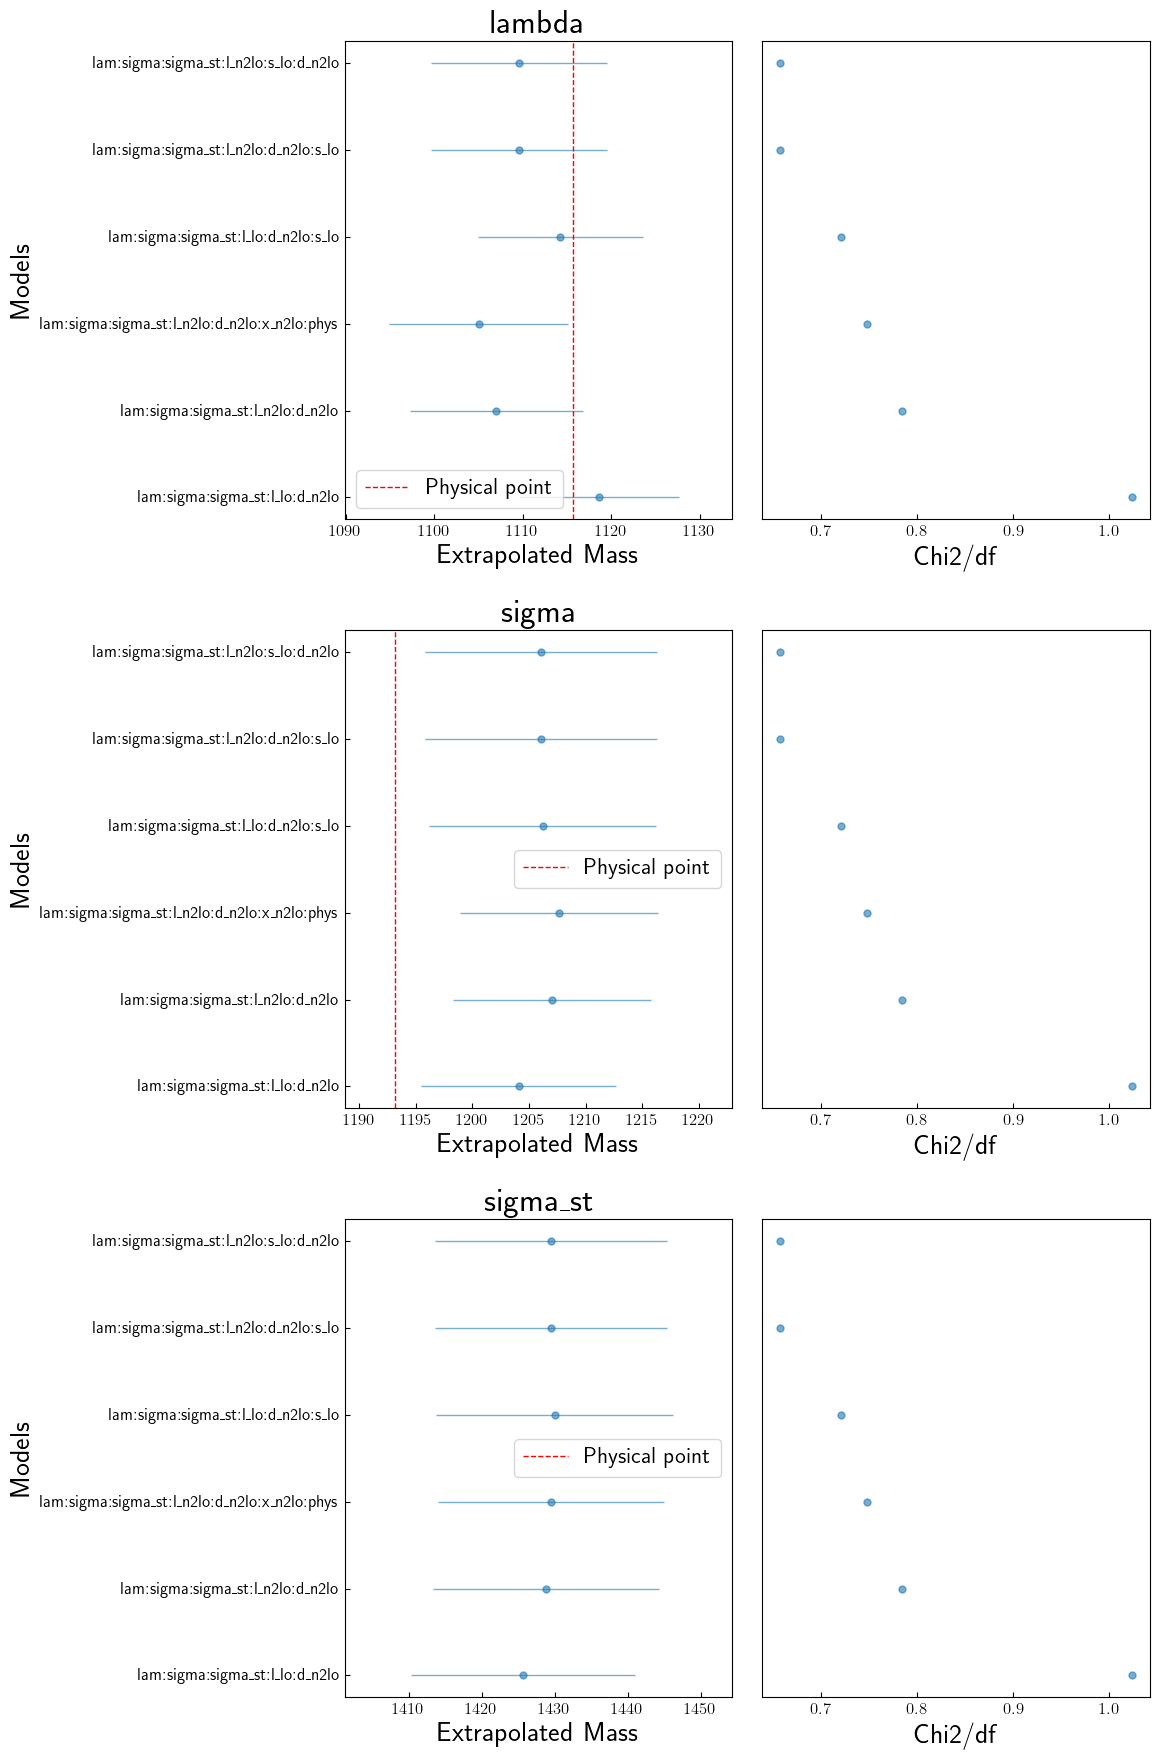

In [ ]:
reload(xfa)
reload(fit)
import lsqfitics
for mdl_key in lam_sigma_models:
    model_info_ = lam_sigma_models[mdl_key]
    # try:
    extrap_analysis_lam = xfa.Xpt_Fit_Analysis(verbose=True, phys_point_data=phys_point_data,
                            data=data, model_info=model_info_, prior=new_prior,project_path=data_dir)
    fit_out_lam = extrap_analysis_lam.fit
#     # print(fit_out_lam)
#     print(extrap_analysis_lam)
    # except Exception as e:
    #     print(f"Error encountered for Model: {mdl_key}")
    #     print(f"Error details: {e}")
    #     continue
    
# extrap_analysis.plot_params(xparam='mpi_sq',observables='xi',show_plot=True,units='gev')
extrap_analysis_lam.plot_params(xparam='eps2_a',observables=['lambda','sigma','sigma_st'],show_plot=True,eps=False)
    # extrap_analysis.plot_params_fit(param='a',observable='xi',eps=False)
# extrap_analysis.plot_params_fit(param='mpi_sq',observable='xi')

'''model average with lsqfitics'''
# y_fit_ = extrap_analysis.extrapolation()
# print(y_fit_)

compare = xfa.ModelComparsion(verbose=True, phys_point_data=phys_point_data,
                                data=data, models=lam_sigma_models, prior=new_prior,project_path=data_dir)
compare.compare_models(particles=['lambda','sigma','sigma_st'])
compare.model_average(particles=['lambda','sigma','sigma_st'])
compare.model_plots()

In [ ]:
# model_info_fpi = xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo:fpi']
# # fpi units # 
# xi_fit_fpi = fit.FitRoutine(prior=prior_fpi,data=data_units_fpi, project_path=data_dir,model_info=model_info_fpi,
#                     phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)
# # print(xi_fit_fpi)
# # print(xi_fit_fpi.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))
# extrap_analysis_fpi = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
#                                 data=data_units_fpi, model_info=model_info_fpi, prior=new_prior_fpi,project_path=data_dir)
# print(extrap_analysis_fpi)



### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation


In [ ]:
model_info_lam = lam_sigma_models['lam:sigma:sigma_st:l_n2lo:d_n2lo:x_n2lo:phys']
lam_fit = fit.FitRoutine(prior=prior,data=data, project_path=data_dir,model_info=model_info_lam,
                    phys_point_data=phys_point_data, emp_bayes=None,empbayes_grouping=None)

# print(lam_fit)
# print(lam_fit.extrapolation(observables=['sigma_pi','mass'],data=phys_point_data))

In [ ]:
reload(i_o)
xi_out = xi_fit.fit
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
m_proton = xi_out.p['m_{xi,0}']
e_pi = m_pi / lam_chi
# sigma = m_pi**2 *gv.deriv(m_proton, e_pi**2)
# print(sigma)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
term_0 = lam_chi * e_pi/2 * m_proton
term_1 = lam_chi * e_pi/2 * m_proton * e_pi**2*(5/2 - l3/2 - 2*l4 )
term_2 = e_pi**2 * m_proton*(l4-1)
sigma = term_0 + term_1 + term_2
print(term_0,term_1,term_2,sigma)
# sigma_analytic = (e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4 )) *m_proton_deriv) * lam_chi
print('sigma w/ gv.deriv:',sigma)
print('sigma analytic:',sigma_analytic)


NameError: name 'xi_fit' is not defined

In [ ]:

importlib.reload(xfa)
importlib.reload(fit)
importlib.reload(i_o)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior,project_path=data_dir)
    fit_out = extrap_analysis.fit
    for part in mdl_info['particles']:
        extrap_analysis.plot_params(observable=part,xparam='eps2_a',show_plot=True)
        print(f"Model: {mdl_key}")
        # print(fit_out)

    # print(extrap_analysis)

        # return fit_out

with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
for mdl_key in xi_models:
    # mdl_info = xi_models[mdl_key]
    try:
        perform_fit_and_plot(xi_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    


In [ ]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

In [ ]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)